In [1]:
# @title
from IPython.display import display, HTML

display(HTML('''
<div style="display: flex; justify-content: center; align-items: center; text-align: center;">
    <img alt="udeA logo" src="https://github.com/freddyduitama/images/blob/master/logo.png?raw=true" style="width: 107px; height: 152px; margin-right: 20px;">
    <div>
        <h2 style="font-size: 28px;"><strong>Proyecto 3: Filtros</strong></h2>
        <p>Sergio Daza Vasquez - 1010082612</p>
        <p>Natalia Arenas Pachón - 1007729698</p>
        <p>Daniel Barrera Mazo - 1045439175</p>
    </div>
</div>
'''))

In [2]:
!pip install pywavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 26.0 MB/s eta 0:00:00


In [3]:
# Librerias a usar a lo largo de la practica
import seaborn as sns
import matplotlib.pyplot as plt;
import numpy as np;
import scipy.io as sio;
import os
from google.colab import drive
import pandas as pd
from scipy.stats import shapiro , levene, mannwhitneyu
from scipy.stats import kstest, norm
from scipy.signal import detrend
from scipy import fft
import scipy.signal as signal
from scipy.fft import fftfreq
import csv
from statsmodels.robust import mad
import pylab
import statsmodels.api as sm
import pywt
import random
from scipy.signal import detrend
from scipy.signal import butter, filtfilt
from scipy.signal import welch
from scipy.signal.windows import hann

drive.mount('/content/drive')

Mounted at /content/drive


## **Carga de datos**

De la base de datos extraer los registros que correspondan a bradicardia sinusal (SB Sinus Bradycardia) y fibrilación auricular (AFIB Atrial Fibrillation). Esta información está en el archivo Diagnostics.xlsx

De estos registros los análisis para el presente proyecto deben hacerse en la derivación II

In [4]:
archivo_excel = "/content/drive/MyDrive/Colab_Notebooks/Diagnostics.xlsx"

df = pd.read_excel(archivo_excel) # se carga el excel

#filas donde la columna 'Rhythm' sea 'SB' o 'AFIB'
filtros = df[df['Rhythm'].isin(['SB', 'AFIB'])]
filtros.head()

FileName Rhythm      Beat  PatientAge  Gender  \
0  MUSE_20180113_171327_27000   AFIB  RBBB TWC          85    MALE   
1  MUSE_20180112_073319_29000     SB       TWC          59  FEMALE   
3  MUSE_20180113_121940_44000     SB      NONE          66    MALE   
5  MUSE_20180112_120347_79000     SB      NONE          46  FEMALE   
6  MUSE_20180114_075026_69000   AFIB       TWC          80  FEMALE   

   VentricularRate  AtrialRate  QRSDuration  QTInterval  QTCorrected  RAxis  \
0              117         234          114         356          496     81   
1               52          52           92         432          401     76   
3               53          53           96         456          427     34   
5               57          57           70         404          393     38   
6               98          86           74         360          459     69   

   TAxis  QRSCount  QOnset  QOffset  TOffset  
0    -27        19     208      265      386  
1     42         8     215      261      431  
3      3         9     219      267      447  
5     24         9     225      260      427  
6     83        17     215      252      395

In [5]:
total_registros = filtros.shape[0]
print(f"Total de registros con SB y AFIB en la columna 'Rhythm': {total_registros}")

Total de registros con SB y AFIB en la columna 'Rhythm': 5669


### **ECG DATA**

In [6]:
!cp /content/drive/MyDrive/Colab_Notebooks/ECGData.zip .
!unzip ECGData.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: ECGData/MUSE_20180116_125802_57000.csv  
  inflating: ECGData/MUSE_20180116_125812_73000.csv  
  inflating: ECGData/MUSE_20180116_125822_43000.csv  
  inflating: ECGData/MUSE_20180116_125825_58000.csv  
  inflating: ECGData/MUSE_20180116_125842_09000.csv  
  inflating: ECGData/MUSE_20180116_125845_27000.csv  
  inflating: ECGData/MUSE_20180116_125847_39000.csv  
  inflating: ECGData/MUSE_20180116_125906_02000.csv  
  inflating: ECGData/MUSE_20180116_125918_29000.csv  
  inflating: ECGData/MUSE_20180116_125919_34000.csv  
  inflating: ECGData/MUSE_20180116_125921_43000.csv  
  inflating: ECGData/MUSE_20180116_125925_64000.csv  
  inflating: ECGData/MUSE_20180116_125946_45000.csv  
  inflating: ECGData/MUSE_20180116_125948_54000.csv  
  inflating: ECGData/MUSE_20180116_130000_80000.csv  
  inflating: ECGData/MUSE_20180116_130002_89000.csv  
  inflating: ECGData/MUSE_20180116_130009_24000.csv  
  inflating: EC

In [7]:
directorio_actual=os.getcwd()
print(directorio_actual)
archivos = os.listdir(directorio_actual + "/ECGData")
print(len(archivos))
print(filtros.columns)

/content
10646
Index(['FileName', 'Rhythm', 'Beat', 'PatientAge', 'Gender', 'VentricularRate',
       'AtrialRate', 'QRSDuration', 'QTInterval', 'QTCorrected', 'RAxis',
       'TAxis', 'QRSCount', 'QOnset', 'QOffset', 'TOffset'],
      dtype='object')


### **Se filtran los registros dependiendo del estado o condicion (AFIB o SB)**

In [8]:
pacientes_filtrados = filtros['FileName'].tolist() # Lista de nombres de archivos de pacientes filtrados

#filtran los archivos que corresponden a los pacientes filtrados
archivos_filtrados = [archivo for archivo in archivos if archivo.split('.')[0] in pacientes_filtrados]

#listas separadas para SB y AFIB
archivos_SB = [archivo for archivo in archivos_filtrados if filtros[filtros['FileName'] == archivo.split('.')[0]]['Rhythm'].values[0] == 'SB']
archivos_AFIB = [archivo for archivo in archivos_filtrados if filtros[filtros['FileName'] == archivo.split('.')[0]]['Rhythm'].values[0] == 'AFIB']

print(f"Se encontraron {len(archivos_SB)} archivos correspondientes a los pacientes con SB.")
print(f"Se encontraron {len(archivos_AFIB)} archivos correspondientes a los pacientes con AFIB.")

Se encontraron 3889 archivos correspondientes a los pacientes con SB.
Se encontraron 1780 archivos correspondientes a los pacientes con AFIB.


### Ahora, se va a realizar el analisis de cada registro en la derivacion II. Por lo que es necesario crear una funcion que permita obtener los datos asociados a la derivacion II de cualquier registro

In [9]:
column_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ruta_base = os.path.join(directorio_actual, "ECGData")

def cargar_ecg(ruta_base, archivo, column_names):
    ruta_archivo = os.path.join(ruta_base, archivo)
    df_ecg = pd.read_csv(ruta_archivo, names=column_names)
    return df_ecg['II'].values  # Retornar los datos de la columna 'II'

Se almacenan los datos asociados a la derivacion II en un diccionario. Esto para cada condicion (AFIB y SB)

In [10]:
# Diccionario para almacenar los datos de la columna II de cada archivo AFIB
datos_ecg_afib = {}

# Se itera sobre cada archivo en la lista archivos_AFIB
for archivo in archivos_AFIB:
    # Se extraen los datos de la columna II y se almacenan en el diccionario
    datos_ecg_afib[archivo] = cargar_ecg(ruta_base, archivo, column_names)

In [11]:
# Diccionario para almacenar los datos de la columna II de cada archivo SB
datos_ecg_sb_dict = {}

# Se itera sobre cada archivo en la lista archivos_SB
for archivo in archivos_SB:
    # Se extraen los datos de la columna II y se almacenan en el diccionario
    datos_ecg_sb_dict[archivo] = cargar_ecg(ruta_base, archivo, column_names)

### **1. Del artículo: https://www.nature.com/articles/s41598-020-59821-7**

Consultar y explicar los dos métodos de reducción de ruido usados en el artículo: Robust LOESS y Non Local Means (10%), mostrar cómo se podrían implementar en Python (5%)

https://www.tandfonline.com/doi/abs/10.1080/01621459.1979.10481038

<blockquote>

### **1.** Robust LOESS (Locally Estimated Scatterplot Smoothing)

El suavizado de diagramas de dispersión estimados localmente, o LOESS, es un método no paramétrico para suavizar una serie de datos en el que no se realizan suposiciones sobre la estructura subyacente de los datos.

* LOESS utiliza regresión local para ajustar una curva suave a través de un diagrama de dispersión de datos.
* La curva LOESS suele ser más suave que un filtro binomial o un promedio móvil.
* LOESS también es eficaz cuando hay valores atípicos en los datos. La metodología LOESS incluye técnicas para construir intervalos de confianza alrededor de la curva.

</blockquote>

https://www.kaggle.com/code/eugeniyosetrov/lowess-smoother-algorithm

Ahora, siguiendo el código consultado empleando Robust Loess, en nuestro caso se aplicará a una señal de los datos archivos_SB[0] como ejemplo, obteniendo el siguiente suavizado:

Ha de tenerse en cuenta que para este suavizado que el parámetro clave es frac_val, debido a que este parámetro controla la fracción de puntos utilizados en el suavizado para cada ventana. Para este caso, si se aumenta dicho valor se suavizará más señal por lo que se definió un valor de 0.02 en donde se observó que no se perdian los picos característicos de la señal ECG.También, es importante recalcar que para ambos suavizados se graficó la señal de 0 a 1 (en el eje x) para observar más a detalle el comportamiento de ambos suavizados en la señal de ejemplo.

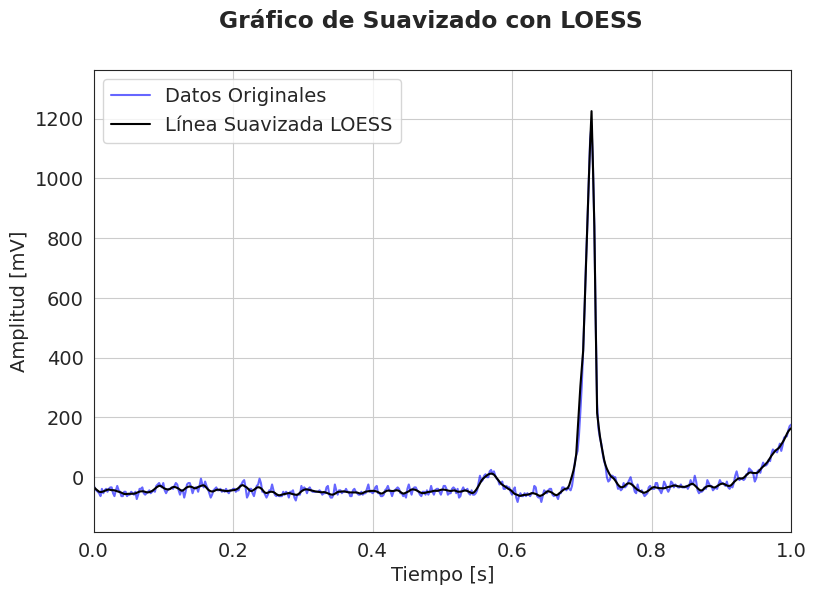

In [12]:
import os
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pylab
import seaborn as sns

sns.set_style("white")
pylab.rc("figure", figsize=(9, 6))
pylab.rc("font", size=14)

ruta_base = os.path.join(directorio_actual, "ECGData")
registro = archivos_SB[0]
datos_ecg_sb2 = cargar_ecg(ruta_base, registro, column_names)
datos_ecg_sb2 = np.array(datos_ecg_sb2[1:], dtype=float)

fs = 500
tiempo = np.arange(0, len(datos_ecg_sb2) / fs, 1 / fs)

# Aplicar el suavizado LOESS a los datos
frac_val = 0.002
smoothed = sm.nonparametric.lowess(datos_ecg_sb2, tiempo, frac=frac_val)

fig, ax = pylab.subplots()
ax.plot(tiempo, datos_ecg_sb2, label="Datos Originales", color="blue", alpha=0.6)
plt.suptitle("Gráfico de Suavizado con LOESS", fontweight='bold')
ax.plot(smoothed[:, 0], smoothed[:, 1], color="k", label="Línea Suavizada LOESS")
ax.set_xlim(0, 1)
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud [mV]")
plt.legend()
plt.grid()
plt.show()

<blockquote>

### **2.** Non Local Means (NLM)


El objetivo de esta técnica de filtrado es solucionar los problemas
asociados con los filtros de suavizado local calculando el
valor suavizado como un promedio ponderado de otros valores en
la serie temporal en función de la similitud entre los
neighbourhoods alrededor del valor de la serie temporal. NLM es un
método de eliminación de ruido que preserva los bordes. El filtro NLM considera el promedio de los píxeles que tienen mayor similitud, en
lugar de uno más cercano. Por otra parte, debido a la complejidad
computacional, la similitud no se calcula entre dos píxeles cualesquiera
en todo el dominio, sino dentro de una ventana de
búsqueda, por lo que el término es “no local” y no “global”.
En el algoritmo de medias no locales, los valores suavizados se dan
por:<br>

$$S(i) = \frac{1}{Z(i)} \sum_{j\in N(i)} w(i, j)D(j)$$

<b>Donde:</b><br>
* $S(i)$ es el valor denoised del punto $i$.<br>
* $N(i)$ es el conjunto de puntos en el rango de $i$.<br>
* $w(i, j)$ es el peso entre los puntos $i$ y $j$, determinado por una medida de similitud.<br>
* $D(j)$ es el valor del punto $j$ en la señal original.<br>
* $Z(i)$ es un factor de normalización, dado por:<br>

$$Z(i) = \sum_{j} w(i, j)$$

El peso $w(i, j)$ se define como:
$$w(i, j) = \exp\left( - \frac{\sum_{\delta \in \Delta} \left[D(i + \delta) - D(j + \delta)\right]^2}{2L_\Delta \lambda^2} \right)$$

<b>Donde:</b><br>
$\lambda$ es un parámetro de suavidad.<br>
$\Delta$ es un parche local de muestras alrededor de $i$ y $j$, que contiene $L_{\Delta}$ muestras.
</blockquote>

https://www.ijarcce.com/upload/2016/january-16/IJARCCE%2042.pdf

Se debe tener en cuenta que este algoritmo para señales ECG han de considerarse los siguientes parámetros:

* **Ventanas de Parche y de Búsqueda:** Para señales ECG, un tamaño de parche que incluya un segmento suficiente del ciclo cardíaco (por ejemplo, una parte de la onda QRS o un ciclo completo) puede mejorar el resultado del filtro.

* **Parámetro de Suavidad:** El parámetro 𝜆 controla la sensibilidad del filtro NLM y debe ser optimizado para no suavizar en exceso los picos importantes (P, QRS, T) en el ECG.

* **Estimación de la Variabilidad del Ruido:** Se puede usar la desviación estándar o el "Median Absolute Deviation" (MAD) para estimar el nivel de ruido en la señal ECG, como se sugiere en el artículo.

De acuerdo con el artículo, se empleará de igual forma para señales ECG configurando el tamaño de la ventana de parche en 10 y el parámetro de control de suavidad λ en 1.5, y el tamaño de la ventana de búsqueda como 20.

Similarmente, se realiza la implementacion de NLM a una de las señales del set de datos.

In [13]:
def non_local_means_ecg(ecg_signal, patch_size=10, search_window=20, lambda_param=1.5):
    """
    Aplica Non-Local Means (NLM) a una señal ECG para reducir el ruido mientras preserva detalles importantes.

    Parámetros:
    - ecg_signal: numpy array, la señal ECG a procesar.
    - patch_size: int, tamaño de cada parche para comparar similitudes.
    - search_window: int, rango de búsqueda alrededor de cada punto.
    - lambda_param: float, parámetro de suavidad que ajusta la sensibilidad del filtro.

    Retorna:
    - smoothed_signal: numpy array, señal ECG suavizada.
    """

    smoothed_signal = np.zeros_like(ecg_signal)
    Z = np.zeros_like(ecg_signal)

    #Calculo del desvío de ruido usando MAD (Median Absolute Deviation)
    noise_estimate = np.median(np.abs(ecg_signal - np.median(ecg_signal))) / 0.6745
    adjusted_lambda = lambda_param * noise_estimate

    #Aplicar NLM en cada punto de la señal ECG
    for i in range(len(ecg_signal)):
        #Parche centrado en i
        patch_i = ecg_signal[max(i - patch_size, 0):min(i + patch_size + 1, len(ecg_signal))]

        for j in range(max(i - search_window, 0), min(i + search_window + 1, len(ecg_signal))):
            #Parche alrededor de j
            patch_j = ecg_signal[max(j - patch_size, 0):min(j + patch_size + 1, len(ecg_signal))]

            min_len = min(len(patch_i), len(patch_j))
            patch_i_adjusted = patch_i[:min_len]
            patch_j_adjusted = patch_j[:min_len]

            dist = np.sum((patch_i_adjusted - patch_j_adjusted) ** 2)

            weight = np.exp(-dist / (adjusted_lambda * patch_size ** 2))

            smoothed_signal[i] += weight * ecg_signal[j]
            Z[i] += weight

    smoothed_signal /= Z
    return smoothed_signal

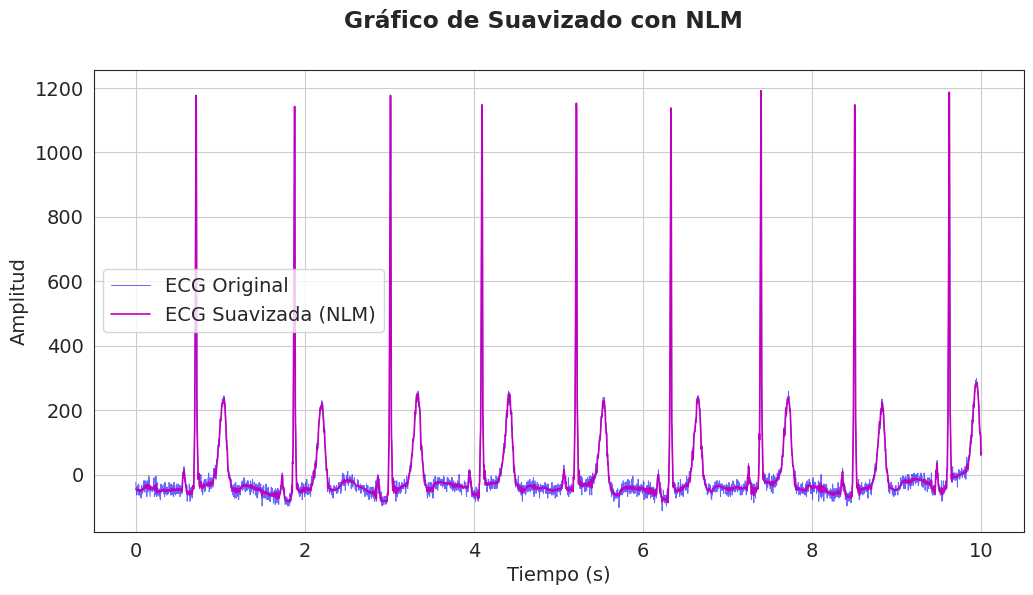

In [14]:
ruta_base = os.path.join(directorio_actual, "ECGData")
registro = archivos_SB[0]  # Primer dato de la segunda derivación de SB

datos_ecg_sbp = cargar_ecg(ruta_base, registro, column_names)

datos_ecg_sbp = np.array(datos_ecg_sbp[1:], dtype=float)

fs = 500  # Frecuencia de muestreo en Hz
tiempo = np.arange(0, len(datos_ecg_sbp) / fs, 1 / fs)

# Aplicar el filtro NLM a la señal de ECG cargada
ecg_suavizada = non_local_means_ecg(datos_ecg_sbp, patch_size=10, search_window=20, lambda_param=1.5)

plt.figure(figsize=(12, 6))
plt.plot(tiempo, datos_ecg_sbp, label='ECG Original', color="blue", alpha=0.6, linewidth=0.7)
plt.plot(tiempo, ecg_suavizada, label='ECG Suavizada (NLM)', color='m', linewidth=1.2)
plt.suptitle("Gráfico de Suavizado con NLM", fontweight='bold')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.legend()
plt.grid()
plt.show()

### **3.** Consultar que otros tipos de señales wavelet se pueden usar para el análisis de señales ECG y adaptar el código del filtro wavelet que se entrega en el curso de acuerdo a la consulta (10%)

**Elección tipo de Wavelet:**

El ECG es una señal biológica que generalmente cambia su propiedad fisiológica y estadística con respecto al tiempo, tendiendo a ser una señal no estacionaria. Durante el registro de señales ECG, el ruido y los artefactos pueden distorsionar los datos debido a fuentes externas o al movimiento del paciente. Esto afecta la forma de onda y dificulta un diagnóstico preciso, comprometiendo la fiabilidad de la lectura. Entre los tipos de ruido más comunes están la interferencia de la línea eléctrica, artefactos de movimiento, problemas de contacto de electrodos y ruido blanco gaussiano, todos los cuales introducen frecuencias altas que dificultan la interpretación de la señal [1]. Por esta razón el estudio de este tipo de señales, mediante transformadas Wavelet resultan muy útiles, ya que permiten la eliminación de la desviación de la línea base y la eliminación del ruido de alta frecuencia.

El análisis de la variabilidad de la frecuencia cardíaca proporciona información importante para comprender los mecanismos fisiológicos, de manera que es una herramienta muy util para la predicción del riesgo en enfermedades cardíacas, como las arritmias [2]. En la literatura se sugiere el número de filtros Wavelet, pero cada filtro de tiene una categoría específica de aplicación. El filtro Wavelet seleccionado debe ser apropiado para la señal fisiologica de nuestro interes, en este caso señales cardicas, ademas debe ser adaptable a la variación lenta y rápida de la señal. Por esta razón para realizar una selección apropiada del filtro Wavelet se realizo una investigación exaustiva de estudios recientes en los que se utilizara Wavelet para filtrar señales ECG.

En la investigación realizada se han identificado varios tipos de wavelets que se utilizan para la eliminación de ruido en señales mediante la Transformada Wavelet Discreta (DWT), tales como 'Haar', 'Daubechies', 'Symlets', 'Coiflet' y 'Biortogonales' [3,4]. La mayoría de los estudios evalúan el orden más adecuado para cada uno de estos wavelets. En general, los wavelets Daubechies han demostrado ser efectivos en la eliminación de diversas desviaciones de la línea base, destacándose el Daubechies de orden 3 (db3) por su desempeño óptimo [5,6]. Aunque algunos estudios también han utilizado el orden 10 con resultados aceptables, un orden tan elevado puede hacer que el filtro se desborde [7]. En la mayoría de los casos, el Daubechies-3 ha mostrado los mejores resultados, con metrica de evaluación de error cuadratico medio (MSE), QRS detectadas y denotando que se deben al parecido que existe entre esta wavelet y la señal de ECG real, como se menciona en los estudios "Comparing different wavelet transforms on removing electrocardiogram baseline wanders and special trends", "Performance Analysis of Wavelet Filters for Heart Rate Variability Analysis" y "ECG SIGNALS PROCESSING USING WAVELETS"[5,6,8]. De esta manera para este proyecto se usara un Wavelet Daubechies-3.

Nota: Se encontraron articulos que mencionaban tambien la eficiencia del Daubechies-4, por esa razón se realizara una comparación en el resultado del uso de los dos Daubechies para esta data más adelantes.

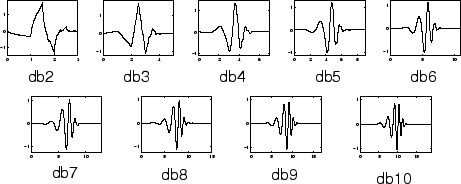

In [17]:
#@title **Tipos de señales Wavelet**
from IPython.display import Image, display
display(Image(filename="/content/drive/MyDrive/Colab_Notebooks/ch01_intro36.gif", width=600, height=300))

Adaptación el código del filtro Wavelet que se entrega en el curso de acuerdo a la consulta.

In [18]:
#filtro wavelet a cada señal y reconstruir
def aplicar_wavelet_filtro(data):
    data_wavelet_filtrada = []
    for senal in data:
        # Calcular el nivel de descomposición wavelet
        level_wv = calcular_nivel_wavelet(senal)
        #wavelet con db3
        coeffs = pywt.wavedec(senal, 'db3', level=level_wv)
        # Aplicar umbral
        _, _, coeffs_filtrados = wthresh(coeffs)
        # Reconstrucción de la señal
        senal_filtrada = pywt.waverec(coeffs_filtrados, 'db3')
        data_wavelet_filtrada.append(senal_filtrada)
    return data_wavelet_filtrada

#ponderación del umbral
def wnoisest(coeff):
    stdc = np.zeros((len(coeff), 1))
    for i in range(len(coeff)):
        stdc[i] = (np.median(np.absolute(coeff[i]))) / 0.6745
    return stdc

#umbral usando la regla universal
def threshold(coeff):
    num_samples = sum([c.shape[0] for c in coeff])
    thr = np.sqrt(2 * np.log(num_samples))
    return thr

#Se aplica el umbral a los detalles de la wavelet
def wthresh(coeff):
    y = []
    s = wnoisest(coeff)  # Obtiene la desviación estándar robusta de cada nivel
    thr = threshold(coeff)  # Calcula el umbral
    for i in range(len(coeff)):
        # Aplica el umbral ponderado a cada nivel de detalle
        y.append(np.multiply(coeff[i], np.abs(coeff[i]) > (thr * s[i])))
    return thr, s, y

#Numero de niveles que se usa en el wavelet
def calcular_nivel_wavelet(data, Nw=2):
    N = len(data)
    max_level = int(np.floor(np.log2(N / (Nw - 1))))
    level_wv = max_level - 2  #Se le merma 1 o 2 porque tomar el nivel exacto trae errores, tomado del profe
    return level_wv

# Función para aplicar el filtro wavelet modificado a una señal
def aplicar_filtro_wavelet(data):
    level_wv = calcular_nivel_wavelet(data)  # Calcular el nivel óptimo de descomposición
    data_wavelet = pywt.wavedec(data, 'db3', level=level_wv)  # Descomposición wavelet

    # Aplicar umbral a los coeficientes de detalle
    _, _, data_wavelet_umbralizado = wthresh(data_wavelet[1:])  # No aplicamos a la aproximación (primer coef.)
    data_wavelet_filtrada = [data_wavelet[0]] + data_wavelet_umbralizado  # Incluye la aproximación sin cambios

    # Reconstrucción de la señal filtrada
    data_filtrada = pywt.waverec(data_wavelet_filtrada, 'db3')
    return data_filtrada


**Justificación de parametros y si se usara FIR o IIR en los flujos.**

Para realizar la elección del tipo de filtro a usar (FIR o IIR), ademas de los parametros a usar en este, se realizo una investigación basada en articulos actuales en los cuales se evidenciara la aplicación y los resultados obtenidos en señales ECG, de los dos tipos de filtros.

Los filtros FIR e IIR muestran una mejora máxima de la SNR cuando se utilizan para eliminar las interferencias de las líneas eléctricas. De ahí que estos filtros sencillos se utilicen con bastante frecuencia para la eliminación de ruido en señales de ECG [9]. En los diferentes articulos evaluados se realizaron estudios en los cuales se compara el rendimiento de varios filtros FIR y IIR para la eliminación del ruido de la señal ECG basándose en su relación señal/ruido (SNR), y pretende encontrar el diseño de filtro más adecuado y el orden óptimo en el que eliminará eficazmente el ruido de ECG. Se establece una relación entre el orden y el SNR para los filtros FIR, en la cual se evidencia que a menor orden menor SNR, sin embargo, al aumentar el orden del filtro FIR se obtiene un mejor rendimiento que con la mayoría de los filtros, pero también aumenta el retardo de fase en la forma de onda junto con el aumento de la complejidad [9], lo cual siguiendo la teoria de clase, no siempre es bueno tener un orden tan elevado. De otra manera se evidencia que los filtros IIR presentan un SNR más alta para un orden menor, lo cual refleja ser un método eficiente en términos de computación, ya un filtro digital IIR de orden bajo, que es mucho más adecuado en gasto computacional que un filtro digital FIR de orden muy alto [10].

Finalmente en el estudio realizado por Thion Ming Chieng "The Study and Comparison between Various Digital Filters for ECG De-noising" se concluye que "Los resultados experimentales y comparativos muestran que los filtros digitales IIR son capaces de eliminar significativamente los ruidos no deseados del ECG, conservando al mismo tiempo la morfología importante de la señal del ECG. En otras palabras, se puede concluir que el método de eliminación de ruido de ECG basado en los filtros digitales IIR supera a los filtros digitales FIR."[11]. Finalmente se selecciono el metodo de diseño de un Butterworth, basandose en los resultados obtenidos en el estudio "Performance Analysis of FIR and IIR Filters for ECG Signal Denoising based on SNR"[12], los cuales realcionan el SNR respecto al orden y teniendo en cuenta que tiene una respuesta de frecuencia suave y sin ondulaciones en la banda de paso, lo que permite conservar las características esenciales de la señal de ECG sin distorsionarlas, a diferencia de las ondulaciones en la banda de paso que generan los Chebyshev y elipticos.


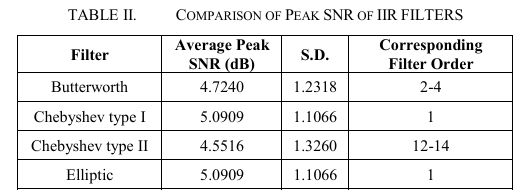

In [19]:
#@title **Parámetros filtro IIR**
from IPython.display import Image, display
display(Image(filename="/content/drive/MyDrive/Colab_Notebooks/FiltroIIR.jpeg", width=400, height=200))

Teniendo esto en claro se usaran las siguiente funciones:

In [20]:
#filtro pasa-altas
def aplicar_filtro_pasaaltas(data, fs, cutoff, order):
    nyquist = 0.5 * fs  # Frecuencia de Nyquist
    normal_cutoff = cutoff / nyquist  # Frecuencia de corte normalizada
    b, a = butter(order, normal_cutoff, btype='high', analog=False)  # Coeficientes del filtro
    data_filtrada = filtfilt(b, a, data)  # Aplicar el filtro
    return data_filtrada

#aplicar filtro pasabajas
def aplicar_filtro_pasabajas(data, fs, cutoff, order):
    nyquist = 0.5 * fs  # Frecuencia de Nyquist
    normal_cutoff = cutoff / nyquist  # Frecuencia de corte normalizada
    b, a = butter(order, normal_cutoff, btype='low', analog=False)  # Coeficientes del filtro
    data_filtrada = filtfilt(b, a, data)  # Aplicar el filtro
    return data_filtrada

Para definir el orden adecuado del filtro IIR con el metodo de diseño Butterworth se hace un analisis en Fourier de los distintos ordenes a continuación.

In [21]:
def plot_freq_response(num, den, filt_order, samp_rate=1):
    freq, response = signal.freqz(num, den)
    response_dB = 20 * np.log10(abs(response))

    plt.figure(figsize=(14, 4))

    # Plot the magnitude response
    plt.subplot(131)
    plt.plot((freq / max(freq)) * samp_rate, abs(response))
    plt.ylabel('Magnitude')
    plt.xlabel(r'Normalized Frequency (xrad/sample)')
    plt.title(f'Frequency Response Order: {filt_order}')
    plt.grid(True)

    # Plot the magnitude in dB
    plt.subplot(132)
    plt.plot((freq / max(freq)) * samp_rate, response_dB)
    plt.ylabel('Magnitude (dB)')
    plt.xlabel(r'Normalized Frequency (xrad/sample)')
    plt.title(f'Magnitude (dB) Order: {filt_order}')
    plt.grid(True)

    # Plot the phase response
    plt.subplot(133)
    phase_response = np.unwrap(np.arctan2(np.imag(response), np.real(response)))
    plt.plot((freq / max(freq)) * samp_rate, phase_response)
    plt.ylabel('Phase (radians)')
    plt.xlabel(r'Normalized Frequency (xrad/sample)')
    plt.title(f'Phase Response - Order: {filt_order}')
    plt.grid(True)

    plt.subplots_adjust(hspace=0.5)
    plt.show()


### **4.** Escoger 10 señales al azar y aplicar un flujo de procesamiento que conste de:

<blockquote>

**Flujo 1**

1. Filtro pasa-altas usando filtro IIR a 0.5 Hz. Justificar la elección de parámetros y si se usa FIR o IIR
2. Filtro wavelet modificado del punto 3
3. Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

**Flujo 2**

1. Detrend
2. Filtro wavelet modificado del punto 3
3. Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

**Flujo 3**

1. Filtro pasa-altas usando filtro IIR a 0.5 Hz. Justificar la elección de parámetros y si se usa FIR o IIR
2. Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR
</blockquote>

## **Nota:**

Con el fin de realizar una comparación adecuada y equitativa entre las señales, se toman 5 señales al azar de los registros de SB y 5 señales al azar de los registros de AFIB, para evaluar un toal de 10 señales al azar.

In [22]:
#Para extraer la señales aleatoriamente
def seleccionar_senales_aleatorias(datos_ecg, num_senales=5):
    archivos_seleccionados = random.sample(list(datos_ecg.keys()), num_senales)
    # Extrae solo los datos numéricos (a partir del índice 1) de las señales seleccionadas
    senales_seleccionadas = [datos_ecg[archivo][1:].astype(float) for archivo in archivos_seleccionados]
    return np.array(senales_seleccionadas)

#5 señales al azar de AFIB y convertirlas en un array de NumPy
senalesAFIB5 = seleccionar_senales_aleatorias(datos_ecg_afib, num_senales=5)
print("Señales AFIB seleccionadas en formato array:")
print(senalesAFIB5)

#5 señales al azar de SB y convertirlas en un array de NumPy
senalesSB5 = seleccionar_senales_aleatorias(datos_ecg_sb_dict, num_senales=5)
print("Señales SB seleccionadas en formato array:")
print(senalesSB5)

Señales AFIB seleccionadas en formato array:
[[-146.4  -146.4  -146.4  ...  292.8   283.04  283.04]
 [ -29.28  -29.28  -19.52 ...   14.64   14.64   14.64]
 [ -34.16  -34.16  -43.92 ...   -4.88  -19.52  -58.56]
 [-117.12 -126.88 -112.24 ...  -92.72  -82.96  -43.92]
 [  19.52   19.52   19.52 ...   82.96   82.96   92.72]]
Señales SB seleccionadas en formato array:
[[ -9.76   0.     0.   ...  -4.88   9.76  14.64]
 [-19.52 -19.52 -19.52 ... -82.96 -82.96 -82.96]
 [ 24.4   19.52   9.76 ...  14.64  19.52  14.64]
 [ -9.76 -43.92 -14.64 ... 117.12  87.84  97.6 ]
 [ 68.32  78.08  87.84 ...  29.28  24.4   39.04]]


Para efectos de visualizacion se grafican las señales extraidas sin filtrar antes de aplicarles los flujos.

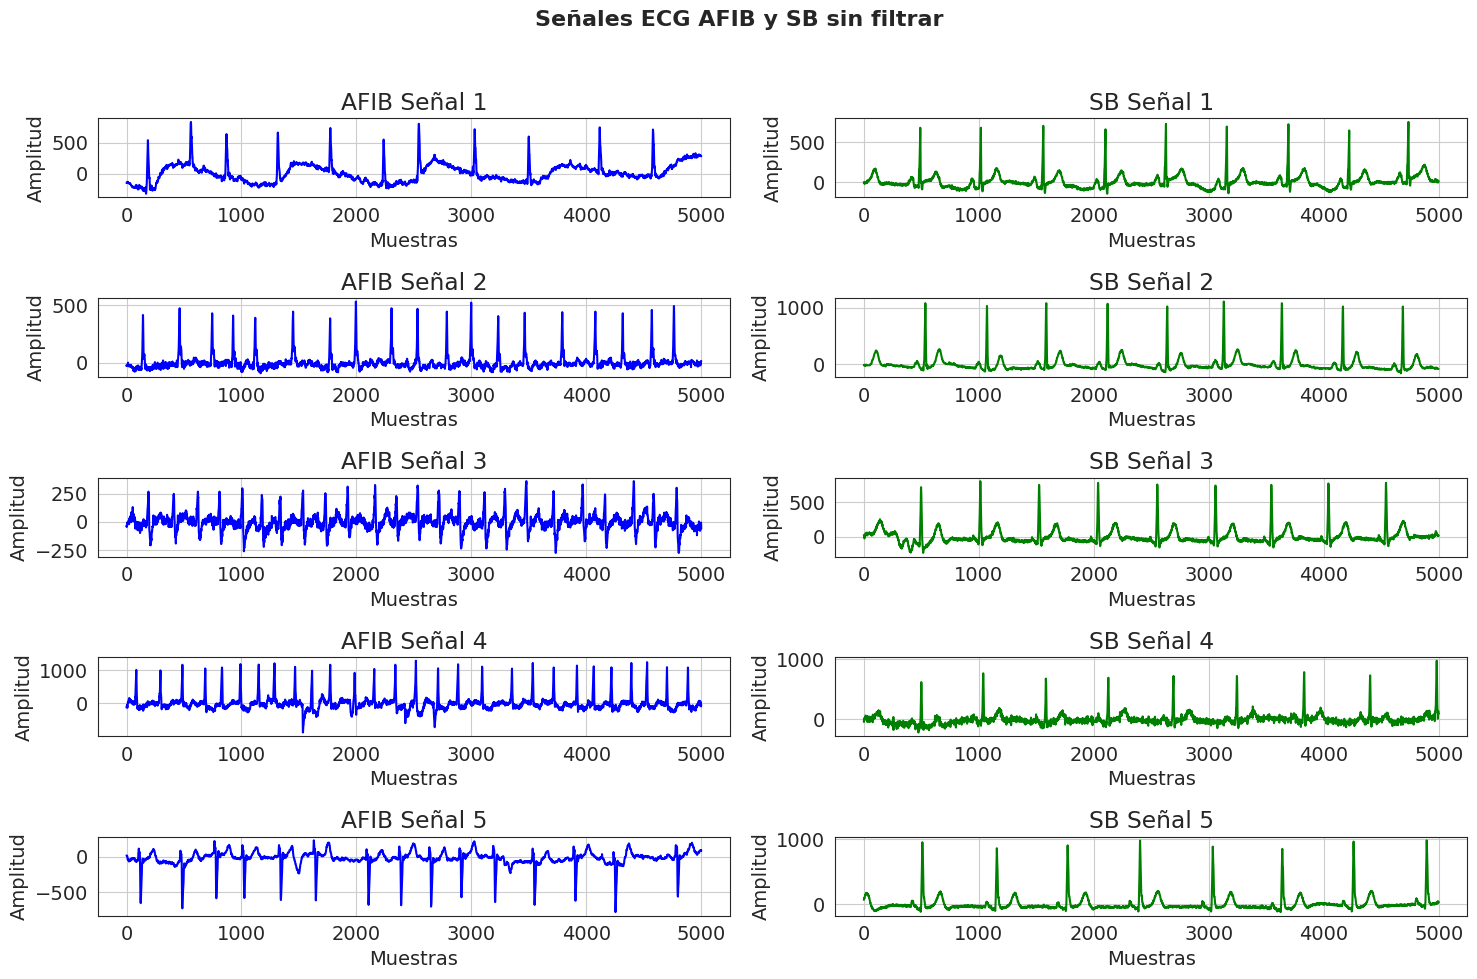

In [23]:
#señales antes del filtrado
def graficar_senales(senalesAFIB, senalesSB):
    plt.figure(figsize=(15, 10))
    plt.suptitle("Señales ECG AFIB y SB sin filtrar", fontsize=16, fontweight='bold')

    # 5 señales de AFIB en los subplots de la izquierda
    for i, senal in enumerate(senalesAFIB):
        plt.subplot(5, 2, 2 * i + 1)
        plt.plot(senal, color='blue')
        plt.title(f"AFIB Señal {i + 1}")
        plt.xlabel("Muestras")
        plt.ylabel("Amplitud")
        plt.grid()

    # 5 señales de SB en los subplots de la derecha
    for i, senal in enumerate(senalesSB):
        plt.subplot(5, 2, 2 * i + 2)
        plt.plot(senal, color='green')
        plt.title(f"SB Señal {i + 1}")
        plt.xlabel("Muestras")
        plt.ylabel("Amplitud")
        plt.grid()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

graficar_senales(senalesAFIB5, senalesSB5)

## **Flujo 1:**

* Filtro pasa-altas usando filtro IIR a 0.5 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

Selección IIR, justificación en la parte de arriba "Justificación de parametros y si se usara FIR o IIR en los flujos."

Justificación de parametros:

-frec de corte = 0.5 Hz

-frec de muestreo = 500 Hz, siguiendo con la del proyecto 2 de acuerdo a la teria señales ECG.

-Orden con la ecuación = Mediante analisis de bode

<ipython-input-21-6672cc53b4e1>:3: RuntimeWarning: divide by zero encountered in log10
  response_dB = 20 * np.log10(abs(response))


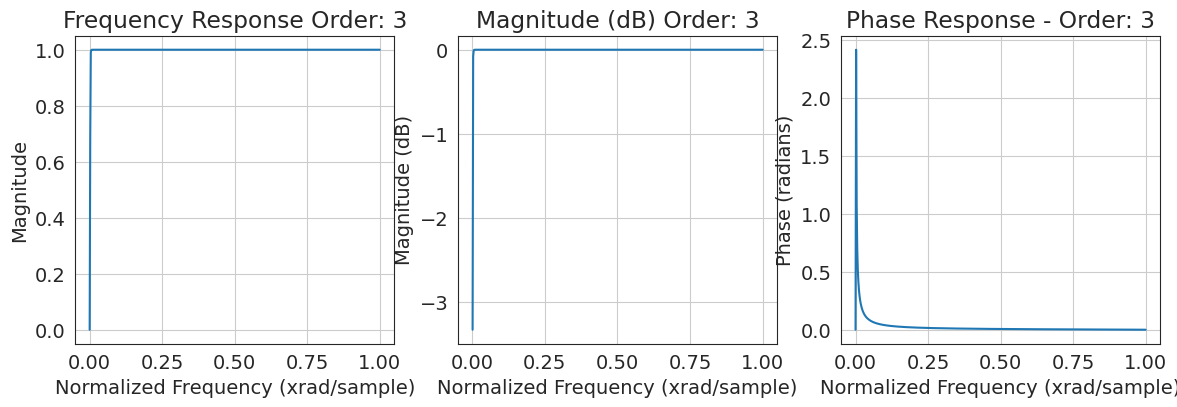

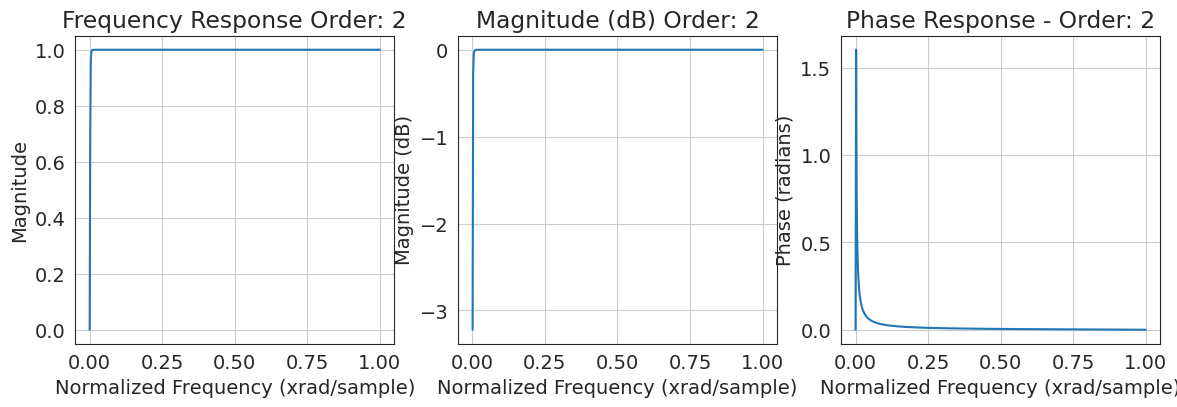

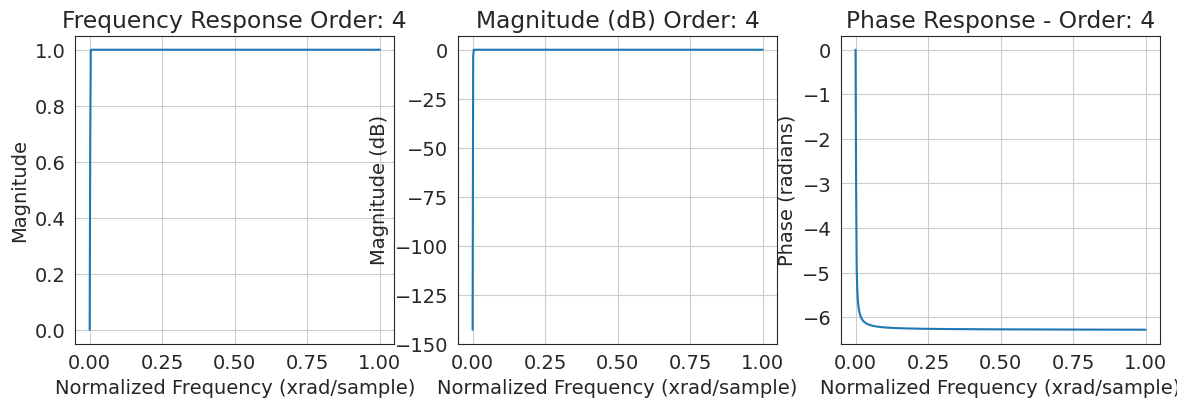

In [24]:
Fs=500  # frec muestreo
nyquist=Fs/2 # teorema de muestreo
Frecorte = 0.5 / nyquist  # frecuencia de corte normalizada respecto nyquist
b_high_3, a_high_3 = signal.iirfilter(3, Frecorte, btype='high', analog=False, ftype='butter')
b_high_2, a_high_2  = signal.iirfilter(2, Frecorte, btype='high', analog=False, ftype='butter')
b_high_4, a_high_4  = signal.iirfilter(4, Frecorte, btype='high', analog=False, ftype='butter')
plot_freq_response(b_high_3,a_high_3,3)
plot_freq_response(b_high_2,a_high_2,2)
plot_freq_response(b_high_4,a_high_4,4)

El filtro de **orden 4** es la mejor elección porque ofrece una mejor atenuación de las frecuencias no deseadas, una banda de paso más definida y una mínima distorsión de fase, lo cual es importante para el análisis de señales ECG. Ahora se procede con el diseño del filtro.

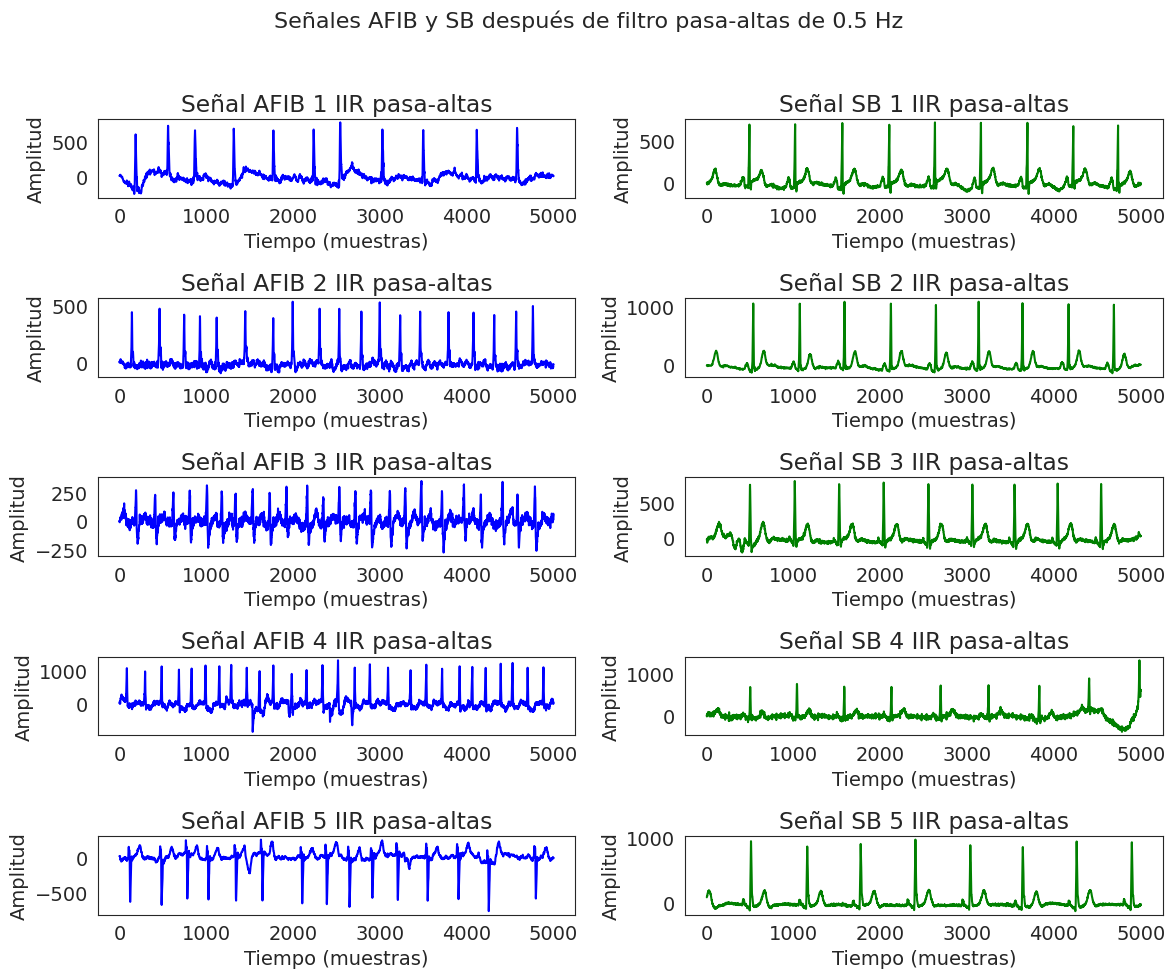

In [25]:
# Filtro pasa altas IIR
cutoff=0.5
order=4 #justificado con el bode
fs = 500

# Aplicar el filtro pasa-altas de 0.5 Hz a las señales originales
senalesAFIB5_filtradas = [aplicar_filtro_pasaaltas(senal, fs, cutoff, order) for senal in senalesAFIB5]
senalesSB5_filtradas = [aplicar_filtro_pasaaltas(senal, fs, cutoff, order) for senal in senalesSB5]

# Graficar los resultados en un subplot de 5 filas y 2 columnas
fig, axes = plt.subplots(5, 2, figsize=(12, 10))
fig.suptitle('Señales AFIB y SB después de filtro pasa-altas de 0.5 Hz', fontsize=16)

for i in range(5):
    axes[i, 0].plot(senalesAFIB5_filtradas[i], color='blue')
    axes[i, 0].set_title(f'Señal AFIB {i+1} IIR pasa-altas')
    axes[i, 0].set_xlabel('Tiempo (muestras)')
    axes[i, 0].set_ylabel('Amplitud')

    axes[i, 1].plot(senalesSB5_filtradas[i], color='g')
    axes[i, 1].set_title(f'Señal SB {i+1} IIR pasa-altas')
    axes[i, 1].set_xlabel('Tiempo (muestras)')
    axes[i, 1].set_ylabel('Amplitud')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


* Filtro wavelet modificado del punto 3, Como se justifico en el punto anterior "Elección tipo de Wavelet", se implementara un filtro Wavelet  Daubechies-3 (db3).

/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  warnings.warn(


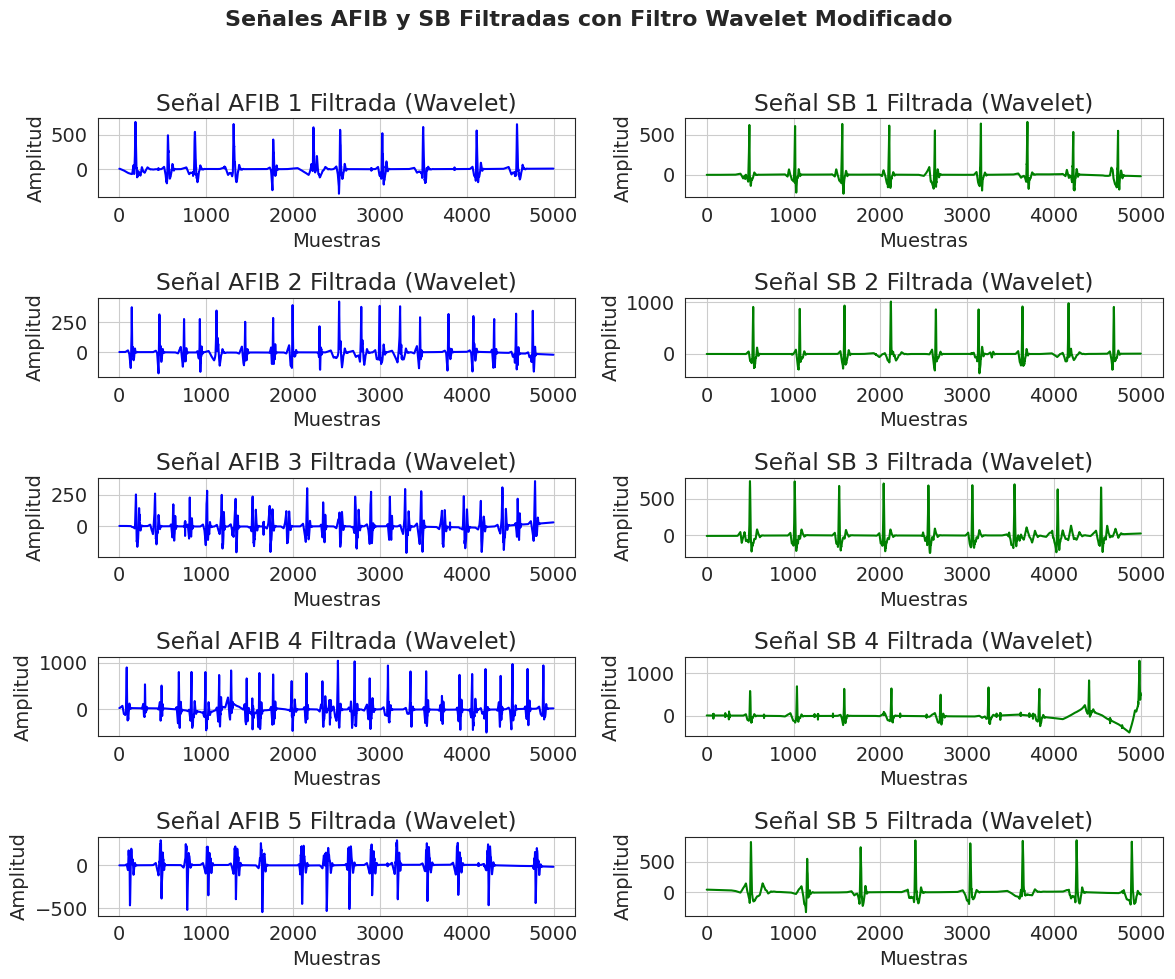

In [26]:
# wavelet modificado del punto 3
#filtro a las señales AFIB y SB
senalesAFIB5_filtradas_wavelet = [aplicar_filtro_wavelet(senal) for senal in senalesAFIB5_filtradas]
senalesSB5_filtradas_wavelet = [aplicar_filtro_wavelet(senal) for senal in senalesSB5_filtradas]

# Configuración del gráfico con subplots de 5 filas y 2 columnas
fig, axes = plt.subplots(5, 2, figsize=(12, 10))
fig.suptitle("Señales AFIB y SB Filtradas con Filtro Wavelet Modificado", fontsize=16, fontweight='bold')

# Graficar las señales AFIB filtradas en la primera columna
for i in range(5):
    axes[i, 0].plot(senalesAFIB5_filtradas_wavelet[i], color='blue')
    axes[i, 0].set_title(f"Señal AFIB {i+1} Filtrada (Wavelet)")
    axes[i, 0].set_ylabel("Amplitud")
    axes[i, 0].set_xlabel("Muestras")
    axes[i, 0].grid()

# Graficar las señales SB filtradas en la segunda columna
for i in range(5):
    axes[i, 1].plot(senalesSB5_filtradas_wavelet[i], color='green')
    axes[i, 1].set_title(f"Señal SB {i+1} Filtrada (Wavelet)")
    axes[i, 1].set_ylabel("Amplitud")
    axes[i, 1].set_xlabel("Muestras")
    axes[i, 1].grid()

# Ajustar el espacio entre los subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

* Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

Selección IIR, justificación en la parte de arriba "Justificación de parametros y si se usara FIR o IIR en los flujos."

Justificación de parametros:

-frec de corte = 50 Hz

-frec de muestreo = 500 Hz, siguiendo con la del proyecto 2 de acuerdo a la teria señales ECG.

-Orden con la ecuación = Mediante analisis de bode

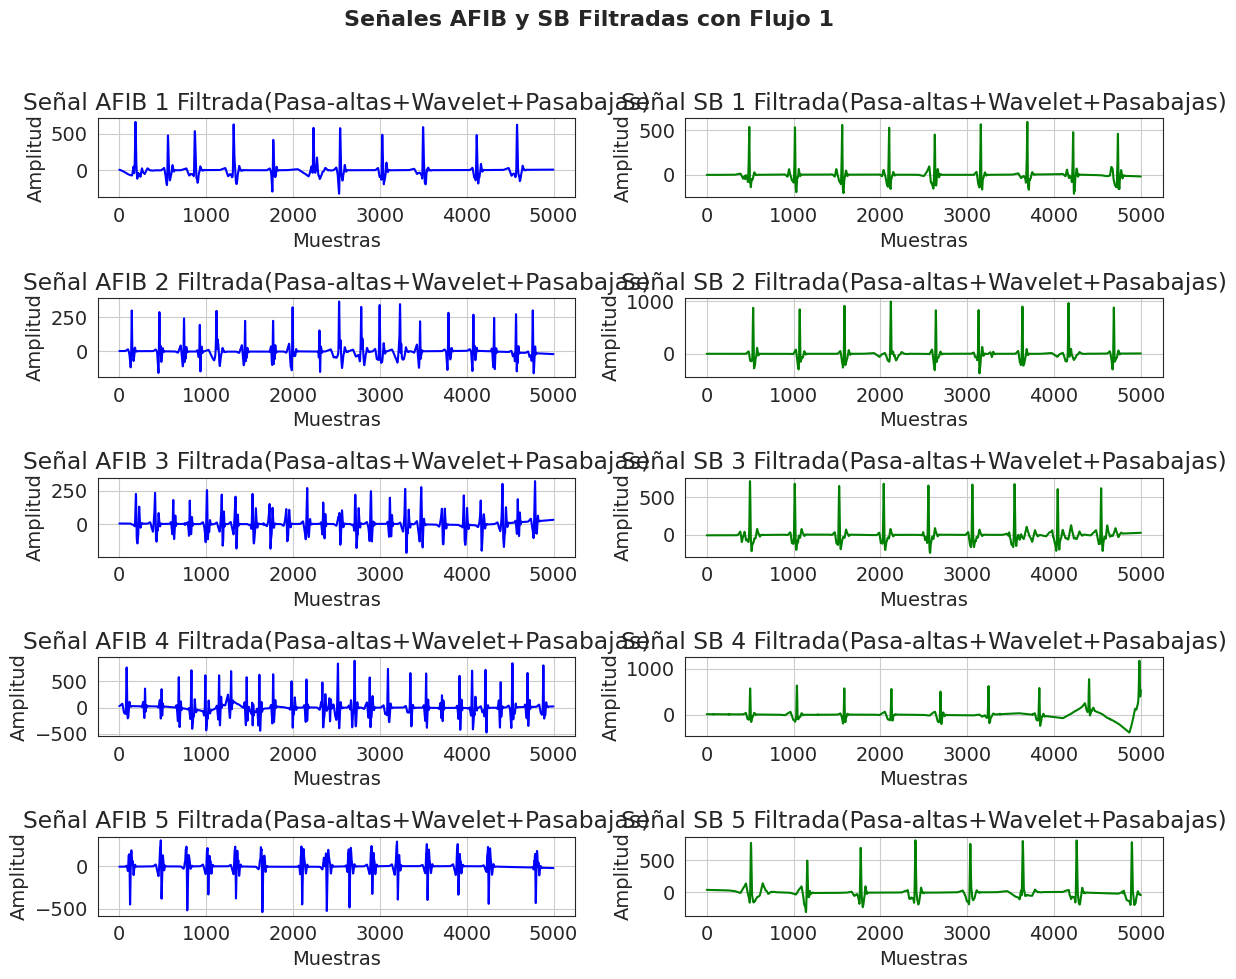

In [27]:
# Filtrado pasabajas 50 Hz
cutoff=50
order=4 #justificado con el bode
fs = 500

# Aplicar el filtro pasabajas a las señales AFIB y SB filtradas con wavelet
senalesAFIB5_filtradas_final = [aplicar_filtro_pasabajas(senal, fs, cutoff, order) for senal in senalesAFIB5_filtradas_wavelet]
senalesSB5_filtradas_final = [aplicar_filtro_pasabajas(senal, fs, cutoff, order) for senal in senalesSB5_filtradas_wavelet]

# Configuración del gráfico con subplots de 5 filas y 2 columnas
fig, axes = plt.subplots(5, 2, figsize=(12, 10))
fig.suptitle("Señales AFIB y SB Filtradas con Flujo 1", fontsize=16, fontweight='bold')

# Graficar las señales AFIB filtradas en la primera columna
for i in range(5):
    axes[i, 0].plot(senalesAFIB5_filtradas_final[i], color='blue')
    axes[i, 0].set_title(f"Señal AFIB {i+1} Filtrada(Pasa-altas+Wavelet+Pasabajas)")
    axes[i, 0].set_ylabel("Amplitud")
    axes[i, 0].set_xlabel("Muestras")
    axes[i, 0].grid()

# Graficar las señales SB filtradas en la segunda columna
for i in range(5):
    axes[i, 1].plot(senalesSB5_filtradas_final[i], color='green')
    axes[i, 1].set_title(f"Señal SB {i+1} Filtrada(Pasa-altas+Wavelet+Pasabajas)")
    axes[i, 1].set_ylabel("Amplitud")
    axes[i, 1].set_xlabel("Muestras")
    axes[i, 1].grid()

# Ajustar el espacio entre los subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Para una mejor visualización se graficara solo una señal antes del filtrado y despues de aplicar todo el flujo 1.

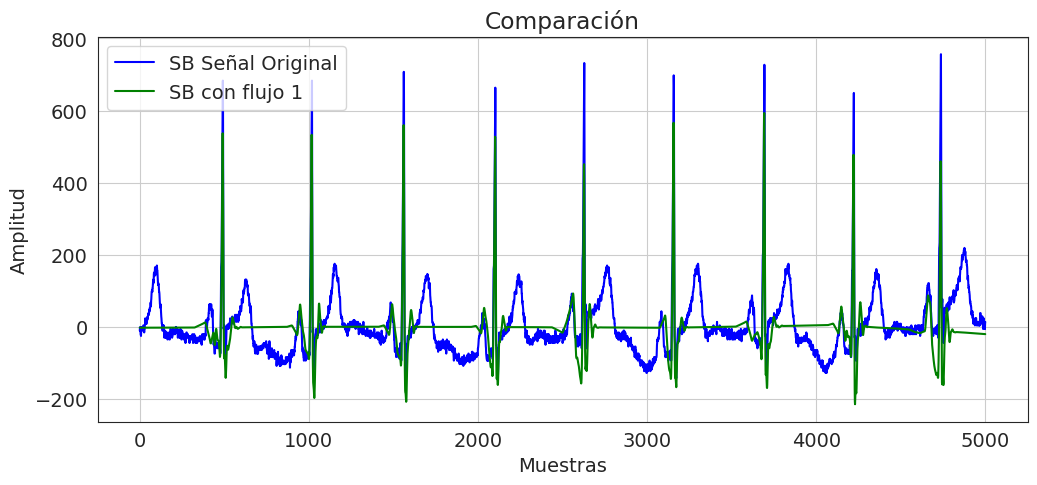

In [28]:
plt.figure(figsize=(12, 5))
# Ajustamos el subplot
plt.plot(senalesSB5[0], color='b', label="SB Señal Original")
plt.plot(senalesSB5_filtradas_final[0], color='green', label="SB con flujo 1")
plt.title("Comparación")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()
plt.legend()  # Añadimos la leyenda

plt.show()

La comparación de la señal SB original y la señal después de aplicar el flujo 1 muestra claramente la efectividad del proceso de filtrado. En la señal sin filtrar, se observan componentes de ruido y distorsiones, mientras que la señal procesada (con el flujo de pasa-altas, wavelet y pasabajas) está mucho más limpia y permite apreciar mejor los elementos clave de la morfología ECG.

Esta visualización confirma que el flujo ha sido capaz de eliminar la mayor parte del ruido no deseado y las frecuencias fuera del rango de interés, sin comprometer la forma de onda crítica.

### **Flujo 2**

* Detrend

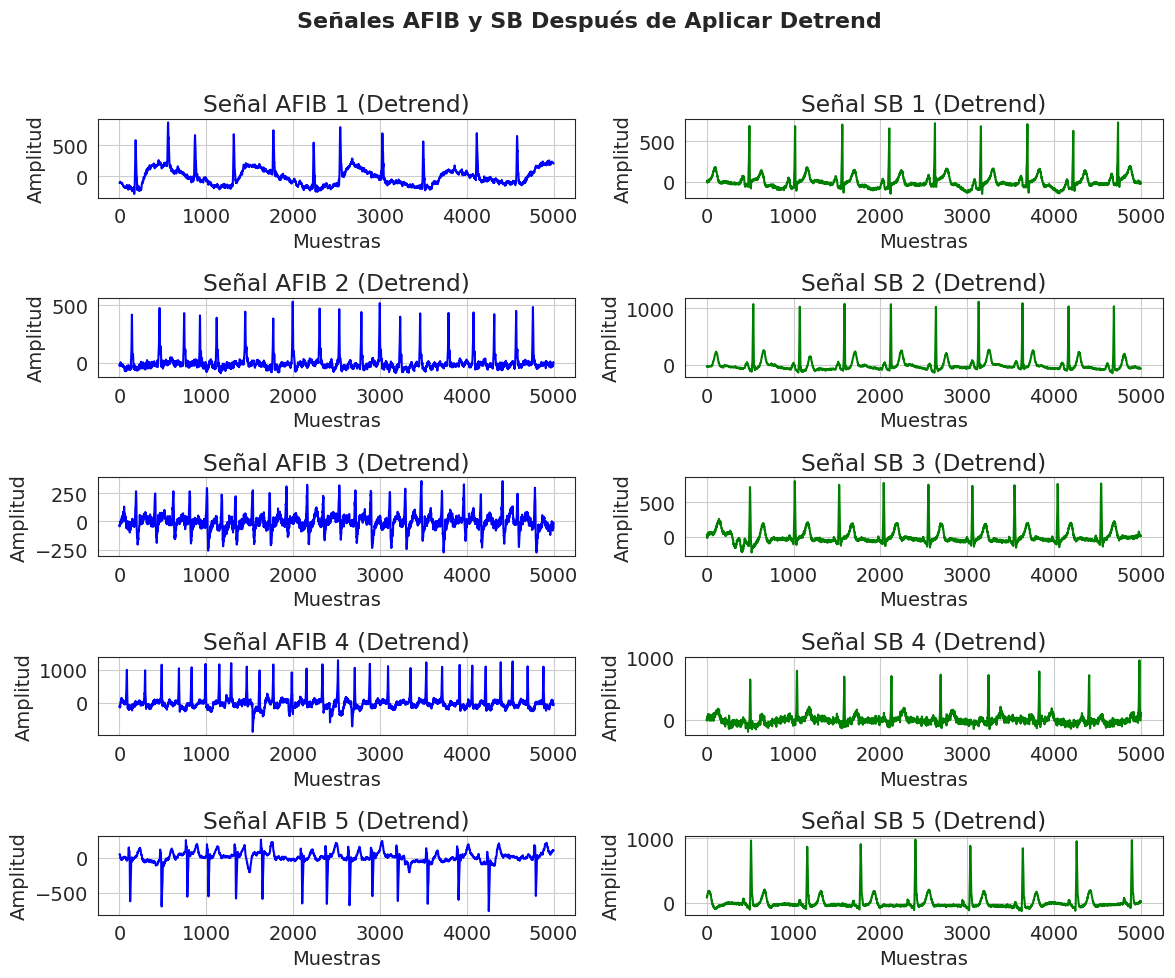

In [29]:

# Aplicar el filtro detrend a cada señal en senalesAFIB5 y senalesSB5
senalesAFIB5_detrend = [detrend(senal) for senal in senalesAFIB5]
senalesSB5_detrend = [detrend(senal) for senal in senalesSB5]

# Configuración del gráfico con subplots de 5 filas y 2 columnas
fig, axes = plt.subplots(5, 2, figsize=(12, 10))
fig.suptitle("Señales AFIB y SB Después de Aplicar Detrend", fontsize=16, fontweight='bold')

# señales AFIB después de aplicar detrend en la primera columna
for i in range(5):
    axes[i, 0].plot(senalesAFIB5_detrend[i], color='blue')
    axes[i, 0].set_title(f"Señal AFIB {i+1} (Detrend)")
    axes[i, 0].set_ylabel("Amplitud")
    axes[i, 0].set_xlabel("Muestras")
    axes[i, 0].grid()

# señales SB después de aplicar detrend en la segunda columna
for i in range(5):
    axes[i, 1].plot(senalesSB5_detrend[i], color='green')
    axes[i, 1].set_title(f"Señal SB {i+1} (Detrend)")
    axes[i, 1].set_ylabel("Amplitud")
    axes[i, 1].set_xlabel("Muestras")
    axes[i, 1].grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

* Filtro wavelet modificado del punto 3, Como se justifico en el punto anterior "Elección tipo de Wavelet", se implementara un filtro Wavelet Daubechies-3 (db3).

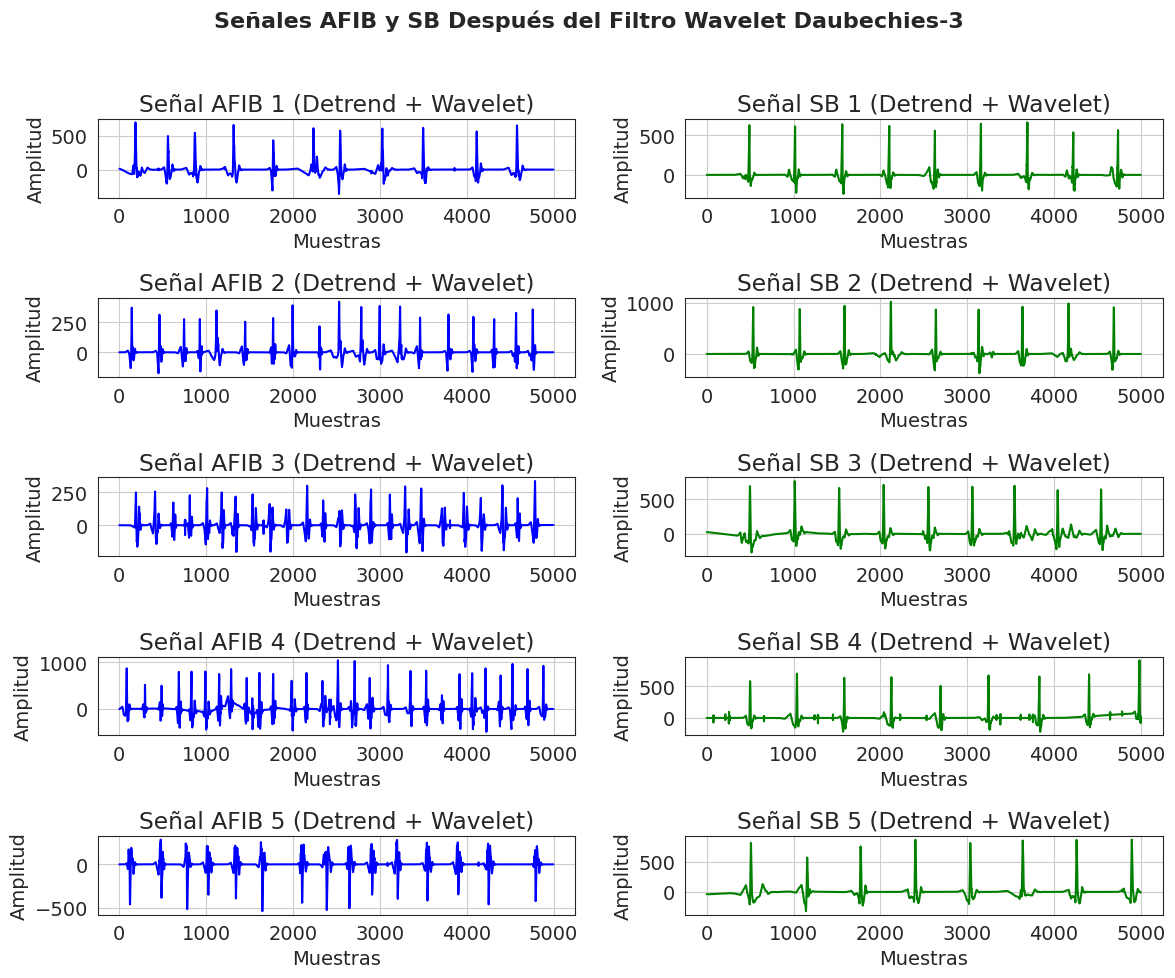

In [30]:
# Filtro wavelet a señales detrend AFIB y SB
senalesAFIB5_detrend_wavelet = aplicar_wavelet_filtro(senalesAFIB5_detrend)
senalesSB5_detrend_wavelet = aplicar_wavelet_filtro(senalesSB5_detrend)

# Visualizacion
fig, axes = plt.subplots(5, 2, figsize=(12, 10))
fig.suptitle("Señales AFIB y SB Después del Filtro Wavelet Daubechies-3", fontsize=16, fontweight='bold')

for i in range(5):
    # Señales AFIB
    axes[i, 0].plot(senalesAFIB5_detrend_wavelet[i], color='blue')
    axes[i, 0].set_title(f"Señal AFIB {i+1} (Detrend + Wavelet)")
    axes[i, 0].set_ylabel("Amplitud")
    axes[i, 0].set_xlabel("Muestras")
    axes[i, 0].grid()

    # Señales SB
    axes[i, 1].plot(senalesSB5_detrend_wavelet[i], color='green')
    axes[i, 1].set_title(f"Señal SB {i+1} (Detrend + Wavelet)")
    axes[i, 1].set_ylabel("Amplitud")
    axes[i, 1].set_xlabel("Muestras")
    axes[i, 1].grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

* Filtrado pasabajas 50 Hz.

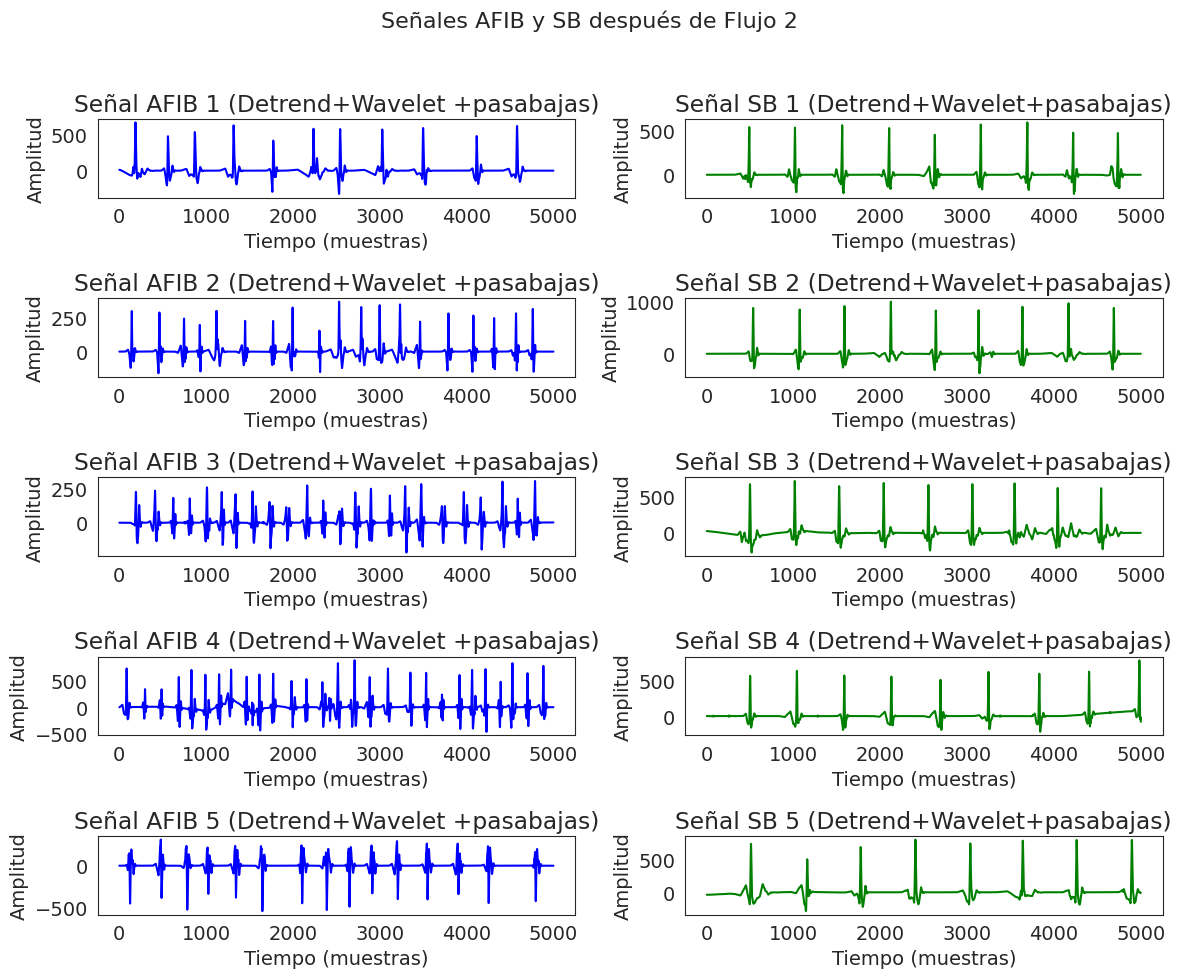

In [31]:
# Parámetros
cutoff=50
order=4 # Justificado con el bode
fs = 500  # Frecuencia de muestreo segun teoria desde proyecto 2

# filtro pasabajas de 50 Hz a las señales detrend + wavelet
senalesAFIB5_detrend_wavelet_pasabajas = [aplicar_filtro_pasabajas(senal, fs, cutoff, order) for senal in senalesAFIB5_detrend_wavelet]
senalesSB5_detrend_wavelet_pasabajas = [aplicar_filtro_pasabajas(senal, fs, cutoff, order) for senal in senalesSB5_detrend_wavelet]

# resultados en un subplot
fig, axes = plt.subplots(5, 2, figsize=(12, 10))
fig.suptitle('Señales AFIB y SB después de Flujo 2', fontsize=16)

for i in range(5):
    axes[i, 0].plot(senalesAFIB5_detrend_wavelet_pasabajas[i], color='blue')
    axes[i, 0].set_title(f'Señal AFIB {i+1} (Detrend+Wavelet +pasabajas)')
    axes[i, 0].set_xlabel('Tiempo (muestras)')
    axes[i, 0].set_ylabel('Amplitud')

    axes[i, 1].plot(senalesSB5_detrend_wavelet_pasabajas[i], color='g')
    axes[i, 1].set_title(f'Señal SB {i+1} (Detrend+Wavelet+pasabajas)')
    axes[i, 1].set_xlabel('Tiempo (muestras)')
    axes[i, 1].set_ylabel('Amplitud')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Para una mejor visualización se graficara solo una señal antes del filtrado y despues de aplicar todo el flujo 2.

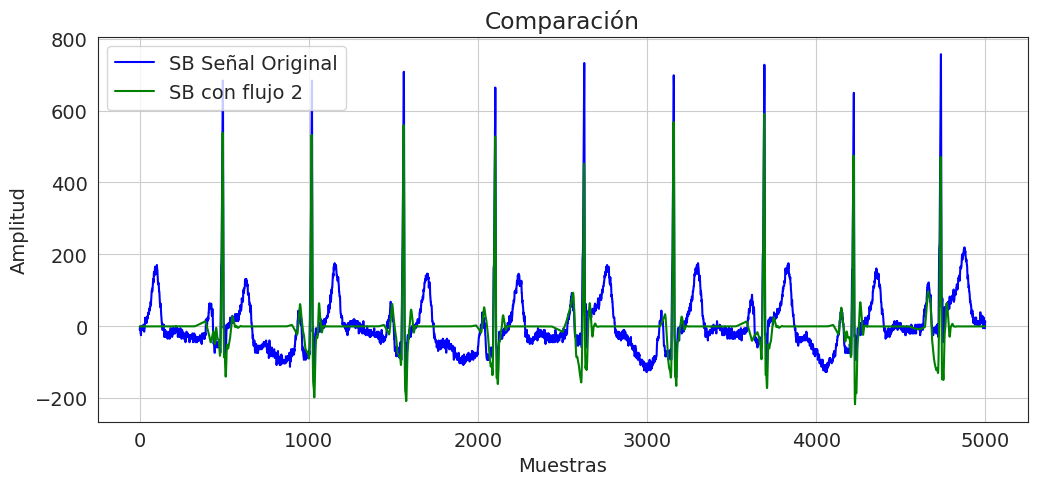

In [32]:
plt.figure(figsize=(12, 5))

plt.plot(senalesSB5[0], color='b', label="SB Señal Original")
plt.plot(senalesSB5_detrend_wavelet_pasabajas[0], color='green', label="SB con flujo 2")
plt.title("Comparación")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()
plt.legend()

plt.show()

Esta visualización comparativa entre la señal SB original y la señal filtrada después de aplicar el Flujo 2 demuestra de manera clara la limpieza y mejora que se ha logrado. Al eliminar las tendencias no deseadas, el ruido de alta frecuencia y las interferencias, la señal resultante es mucho más fácil de interpretar y presenta una dinamica de la senal ECG más definida.

### **Flujo 3**

* Filtro pasa-altas usando filtro IIR a 0.5 Hz.

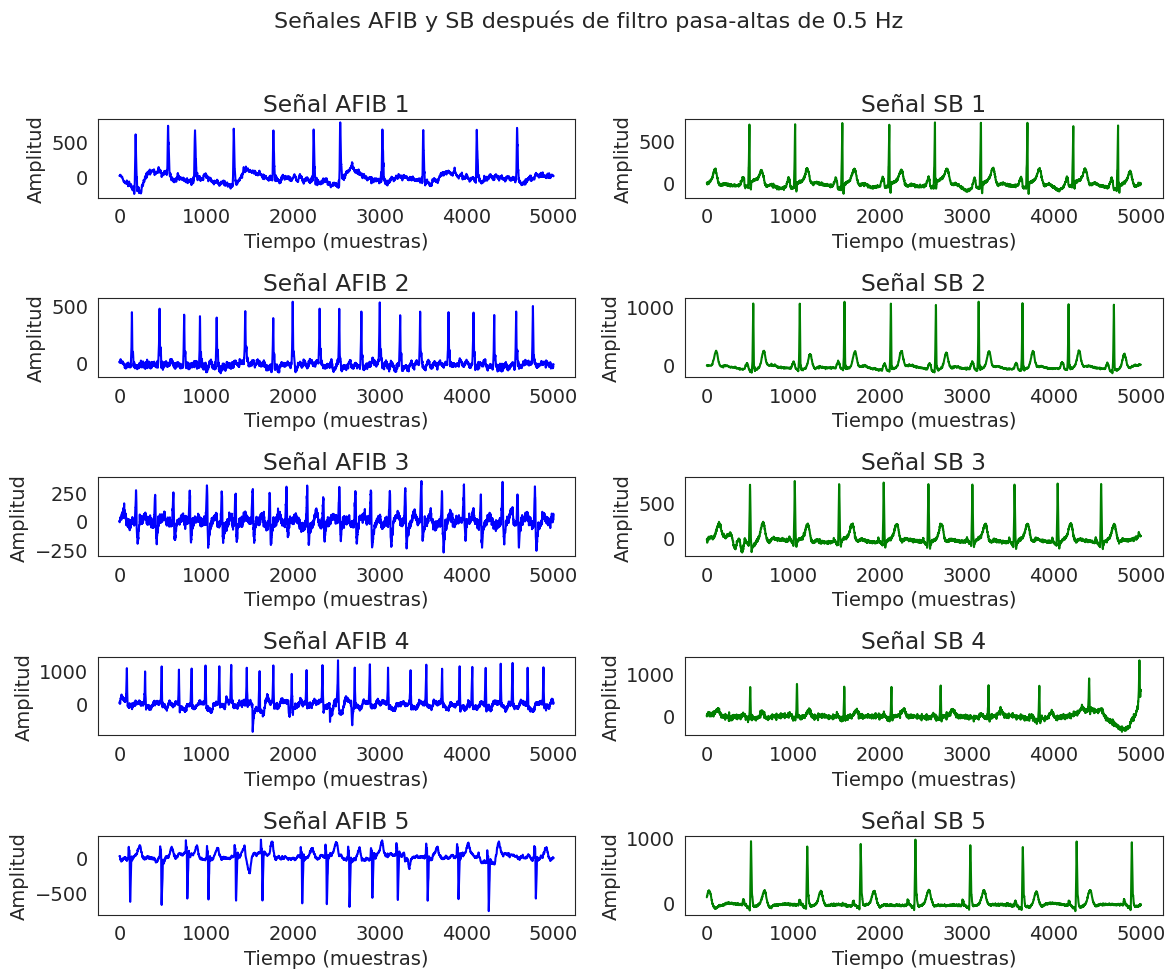

In [33]:
#Flujo 3
# Parámetros
cutoff=0.5
order=4 #justificado con el bode
fs = 500

# Filtro pasa-altas de 0.5 Hz a las señales originales
senalesAFIB5_pasaaltas = [aplicar_filtro_pasaaltas(senal, fs, cutoff, order) for senal in senalesAFIB5]
senalesSB5_pasaaltas = [aplicar_filtro_pasaaltas(senal, fs, cutoff, order) for senal in senalesSB5]

# Visualizacion
fig, axes = plt.subplots(5, 2, figsize=(12, 10))
fig.suptitle('Señales AFIB y SB después de filtro pasa-altas de 0.5 Hz', fontsize=16)

for i in range(5):
    axes[i, 0].plot(senalesAFIB5_pasaaltas[i], color='blue')
    axes[i, 0].set_title(f'Señal AFIB {i+1}')
    axes[i, 0].set_xlabel('Tiempo (muestras)')
    axes[i, 0].set_ylabel('Amplitud')

    axes[i, 1].plot(senalesSB5_pasaaltas[i], color='g')
    axes[i, 1].set_title(f'Señal SB {i+1}')
    axes[i, 1].set_xlabel('Tiempo (muestras)')
    axes[i, 1].set_ylabel('Amplitud')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

* Filtrado pasabajas 50 Hz.

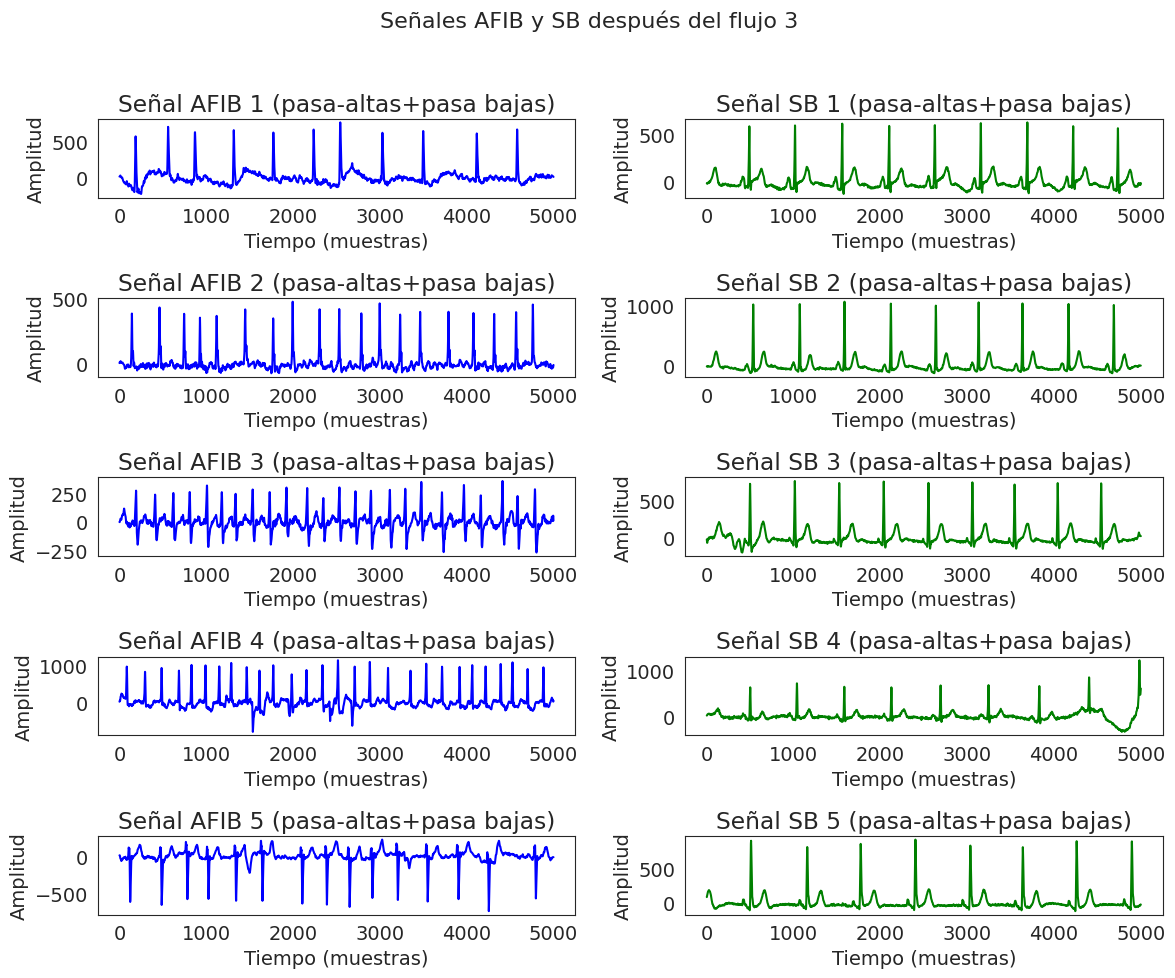

In [34]:
# Parámetros
cutoff=50
order=4 #justificado con el bode
fs = 500

#pasabajas de 50 Hz a las señales filtradas pasa-altas
senalesAFIB5_pasaaltas_pasabajas = [aplicar_filtro_pasabajas(senal, fs, cutoff, order) for senal in senalesAFIB5_pasaaltas]
senalesSB5_pasaalatas_pasabajas = [aplicar_filtro_pasabajas(senal, fs, cutoff, order) for senal in senalesSB5_pasaaltas]

# Visualizacion
fig, axes = plt.subplots(5, 2, figsize=(12, 10))
fig.suptitle('Señales AFIB y SB después del flujo 3', fontsize=16)

for i in range(5):
    axes[i, 0].plot(senalesAFIB5_pasaaltas_pasabajas[i], color='blue')
    axes[i, 0].set_title(f'Señal AFIB {i+1} (pasa-altas+pasa bajas)')
    axes[i, 0].set_xlabel('Tiempo (muestras)')
    axes[i, 0].set_ylabel('Amplitud')

    axes[i, 1].plot(senalesSB5_pasaalatas_pasabajas[i], color='g')
    axes[i, 1].set_title(f'Señal SB {i+1} (pasa-altas+pasa bajas)')
    axes[i, 1].set_xlabel('Tiempo (muestras)')
    axes[i, 1].set_ylabel('Amplitud')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

De nuevo, para una mejor visualización se graficara un segmento de una señal antes del filtrado y despues de aplicar todo el flujo 3.

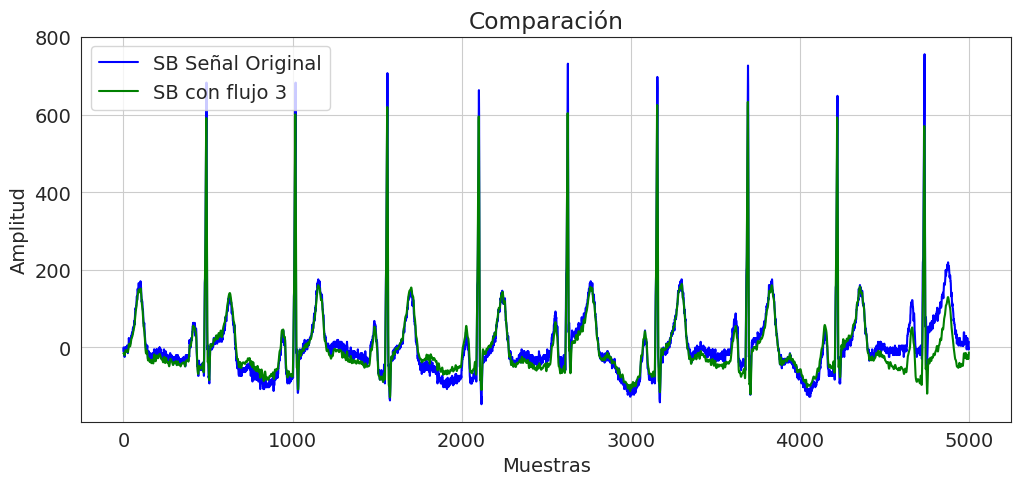

In [35]:
plt.figure(figsize=(12, 5))

plt.plot(senalesSB5[0], color='b', label="SB Señal Original")
plt.plot(senalesSB5_pasaalatas_pasabajas[0], color='green', label="SB con flujo 3")
plt.title("Comparación")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()
plt.legend()

plt.show()

Al observar la señal filtrada con el Flujo 3, se puede notar que algunos detalles de ruido parecen haberse conservado en comparación con los resultados de los otros flujos. Esto podría deberse a que, aunque los filtros pasa-altas y pasa-bajas son efectivos para eliminar ciertos rangos de frecuencia, no necesariamente abordan otros tipos de ruidos más complejos, como los artefactos de movimiento o el ruido de la línea base, que podrían ser mejor tratados con métodos como el filtrado wavelet.

<blockquote>

### **4.1** Describir los resultados obtenidos y decidir si el resto del procesamiento se hace con el flujo 1, el flujo 2 o el flujo 3 (20%)

</blockquote>

Para analizar los resultados obtenidos en la implementación de cada flujo y seleccionar el más adecuado para continuar con el procesamiento de las señales ECG, se ha realizado una visualización comparativa de las señales resultantes tras aplicar cada flujo. Para este análisis, se decidió visualizar la primera señal de bradicardia sinusal (SB), ya que, al ser una señal de menor complejidad en comparación con la fibrilación auricular (AFIB), su dinámica se presta mejor para observar con claridad los efectos de cada técnica de filtrado.

La bradicardia sinusal es una arritmia cardíaca caracterizada por una frecuencia cardíaca baja, pero generalmente regular, donde las ondas P, los complejos QRS y las ondas T suelen tener una morfología constante y predecible. Esta regularidad y la estructura clara de las ondas hacen que la señal SB sea más fácil de interpretar y procesar, con menos variaciones rápidas o caóticas [13]. En contraste, la fibrilación auricular es una arritmia mucho más compleja, con latidos irregulares y una pérdida de la estructura normal de las ondas P, lo que introduce mayor variabilidad y ruido en la señal [14].

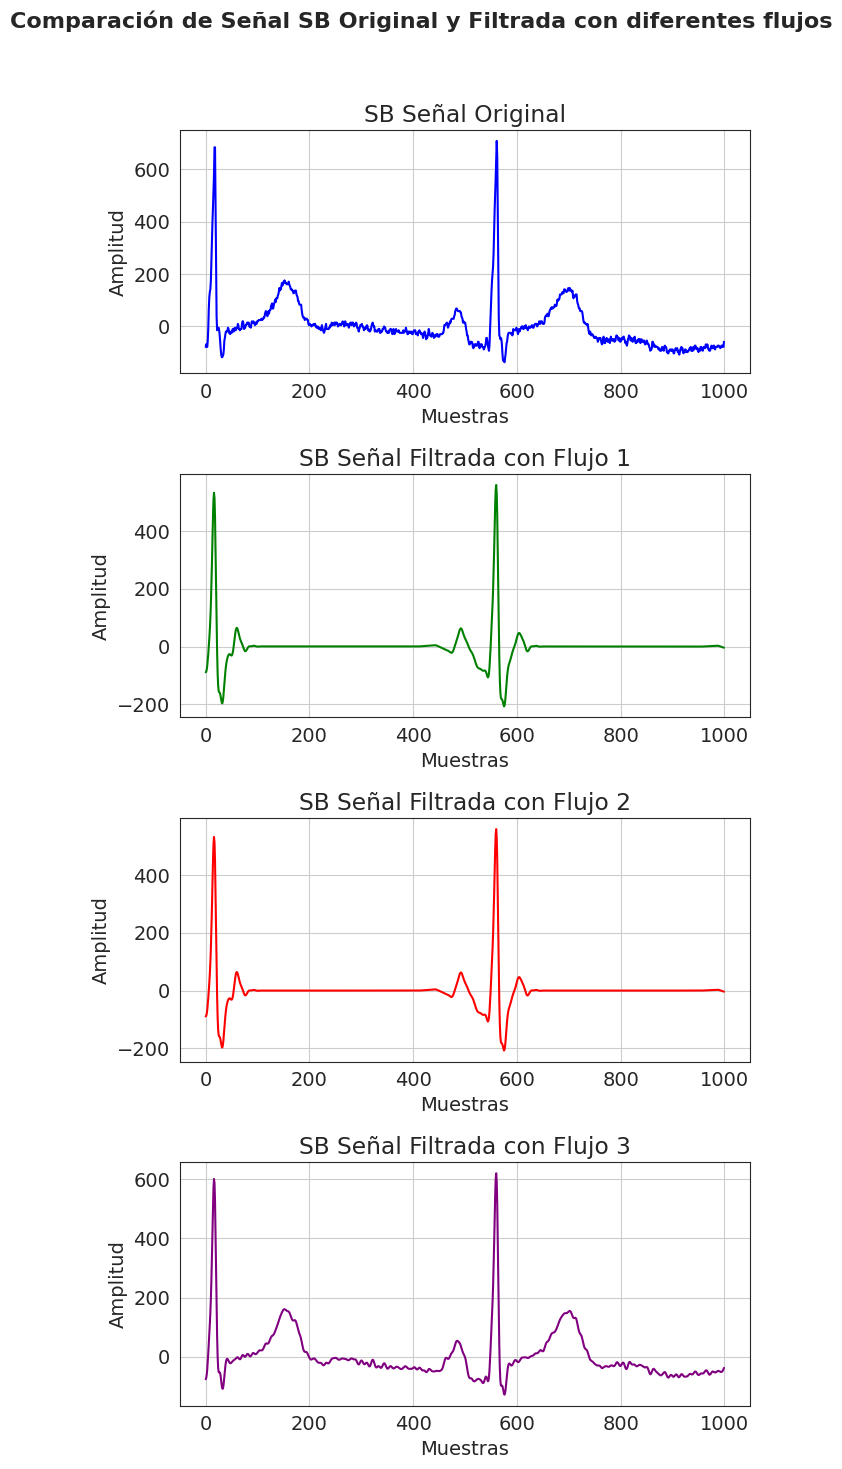

In [36]:
plt.figure(figsize=(7, 15))
plt.suptitle("Comparación de Señal SB Original y Filtrada con diferentes flujos", fontsize=16, fontweight='bold')

# Señal SB Original
plt.subplot(4, 1, 1)
plt.plot(senalesSB5[0][1000:2000], color='blue')
plt.title("SB Señal Original")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()

# Señal SB con Flujo 1
plt.subplot(4, 1, 2)
plt.plot(senalesSB5_filtradas_final[0][1000:2000], color='green')
plt.title("SB Señal Filtrada con Flujo 1")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()

# Señal SB con Flujo 2
plt.subplot(4, 1, 3)
plt.plot(senalesSB5_detrend_wavelet_pasabajas[0][1000:2000], color='red')
plt.title("SB Señal Filtrada con Flujo 2")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()

# Señal SB con Flujo 3
plt.subplot(4, 1, 4)
plt.plot(senalesSB5_pasaalatas_pasabajas[0][1000:2000], color='purple')
plt.title("SB Señal Filtrada con Flujo 3")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

El análisis de los tres flujos de procesamiento implementados permite evaluar su efectividad en la limpieza de señales ECG, tomando como referencia una señal de bradicardia sinusal (SB). Aunque la visualización se ha centrado en una sola señal, es fundamental considerar que el flujo seleccionado se aplicará a un conjunto de datos extenso que incluye tanto señales de SB como de fibrilación auricular (AFIB), estas últimas con una mayor complejidad e irregularidad. Por esta razón, se ha decidido optar por el **Flujo 2**, ya que logra un equilibrio óptimo entre limpieza y eficiencia computacional, asegurando una adecuada eliminación de ruido y preservación de la morfología de las señales, lo que es esencial para el análisis posterior de un dataset diverso y complejo.

Si bien los resultados obtenidos con el **Flujo 1** y el **Flujo 2** son muy similares en términos de limpieza de la señal, la elección del **Flujo 2** se justifica por su mayor eficiencia computacional. Aunque ambos flujos logran eliminar el ruido y preservar la morfología de las señales, el Flujo 1 requiere más pasos de filtrado, incluyendo tanto el filtro pasa-altas como el wavelet antes del pasabajas. Esto resulta en un mayor costo computacional debido a la complejidad adicional en el procesamiento.

En contraste, el **Flujo 2**, al comenzar con el paso de detrend, simplifica el preprocesamiento al eliminar de manera efectiva las fluctuaciones de la línea base desde el inicio, lo que facilita el trabajo del filtro wavelet y el pasabajas posterior. Esto reduce la cantidad de procesamiento necesario sin sacrificar la calidad de la señal final, lo que lo convierte en la mejor opción cuando se trabaja con un gran volumen de señales ECG, muchas de las cuales pueden ser complejas e irregulares.

Por otro lado, **el Flujo 3**, aunque preserva mejor la dinámica original de la señal, mantiene algunos detalles de ruido que no son completamente eliminados. Esto es un problema cuando se aplica a un set de datos más complejo, ya que podrían permanecer interferencias no deseadas, afectando la calidad del análisis posterior, en particular el análisis del espectro de potencia. Estas interferencias residuales dificultarían la correcta identificación de características relevantes en señales más irregulares, como las de fibrilación auricular, complicando el análisis y las conclusiones que se obtienen a partir de esos datos.

<blockquote>

### **4.2** Con el flujo seleccionado procesar las señales de la base de datos ECGData.zip derivación II. En este punto deberíamos estar en el mismo punto donde partimos en el proyecto 2, con señales filtradas.
</blockquote>

En esta parte se crea una funcion la cual realice el proceso de filtrado en el Flujo 2, de modo que posteriormente se pueda implementar en todas las senales ECG.

In [37]:
def flujo_2(data, fs=500, cutoff=50, order=4):
    # Paso 1: Detrend
    data_detrend = detrend(data)

    # Paso 2: Filtro wavelet modificado
    data_wavelet = aplicar_filtro_wavelet(data_detrend)

    # Paso 3: Filtrado pasabajas de 50 Hz
    data_filtrada = aplicar_filtro_pasabajas(data_wavelet, fs, cutoff, order)

    return data_filtrada

A modo de poder ver que el flujo se esta implementando bien, se implementa una señal del diccionario donde se almacenan las senales AFIB

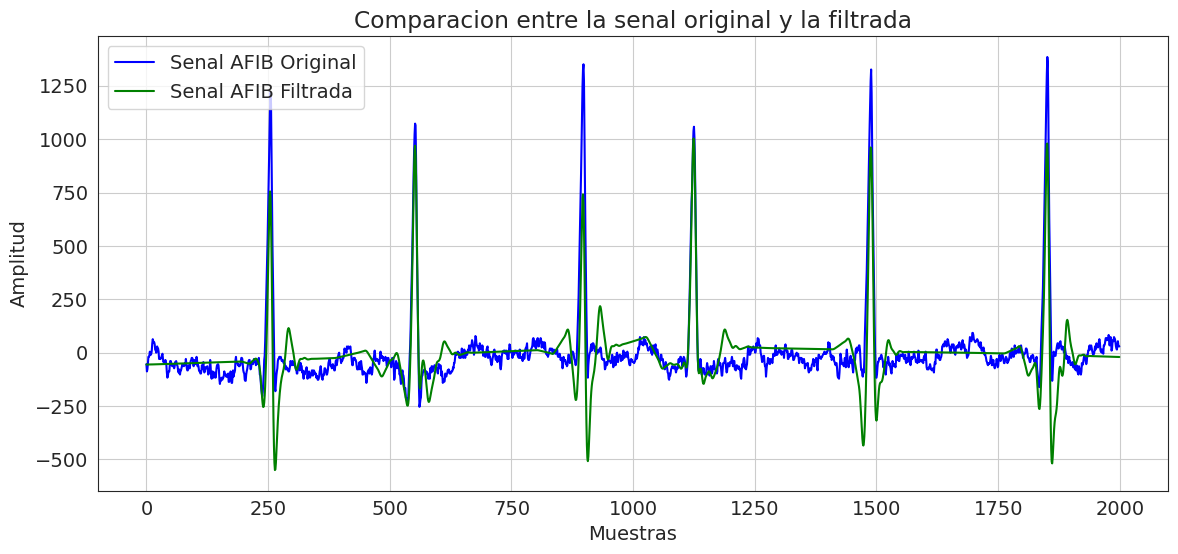

In [38]:
primera_senal_afib = list(datos_ecg_afib.values())[0][1:].astype(float)  # convierte a float y omite el primer valor que es 'II'

# Se aplica el flujo
senal_afib_filtrada = flujo_2(primera_senal_afib, fs)

# Se visualiza la señal original y la señal filtrada
plt.figure(figsize=(12, 6))
plt.plot(primera_senal_afib[0:2000], color='blue', label = 'Senal AFIB Original')
plt.plot(senal_afib_filtrada[0:2000], color='green', label= 'Senal AFIB Filtrada')
plt.title("Comparacion entre la senal original y la filtrada")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.legend()
plt.grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Similarmente para el diccionario donde se almacenan las senales SB

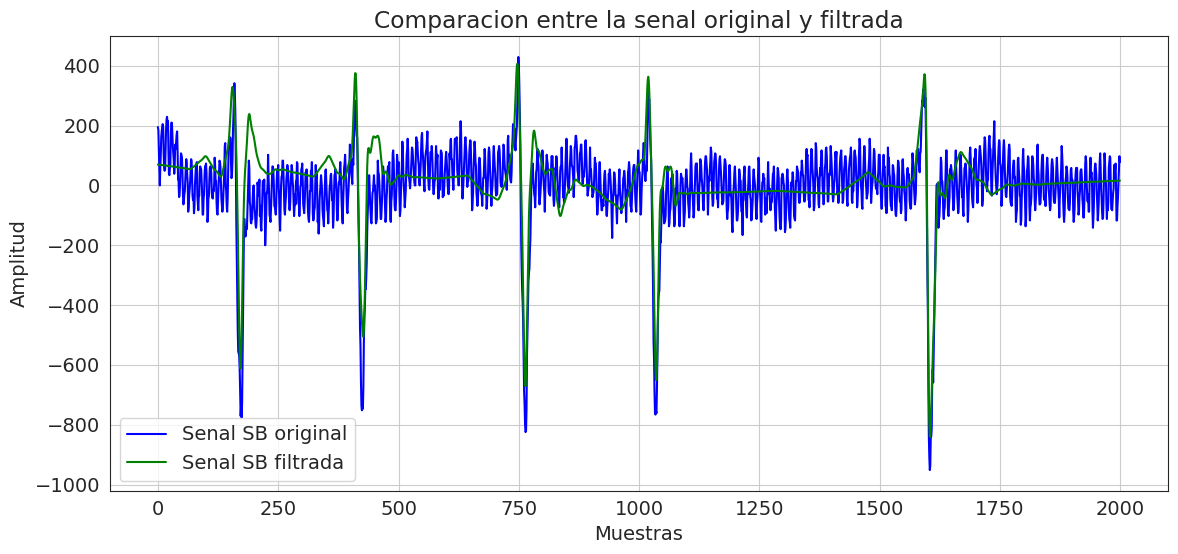

In [39]:
primera_senal_sb = list(datos_ecg_sb_dict.values())[8][1:].astype(float)  # convierte a float y omitir el primer valor que es 'II'

# Se implementa el flujo
senal_sb_filtrada = flujo_2(primera_senal_sb, fs, cutoff=50, order=4)

# Se visualiza la señal original y la señal filtrada
plt.figure(figsize=(12, 6))
plt.plot(primera_senal_sb[0:2000], color='blue', label='Senal SB original')
plt.plot(senal_sb_filtrada[0:2000], color='green', label='Senal SB filtrada')
plt.title("Comparacion entre la senal original y filtrada")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.legend()
plt.grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Ahora se realiza una rutina que implementa el flujo 2 a todas las senales AFIB

In [40]:
# Nuevo diccionario para almacenar las señales filtradas
datos_ecg_afib_filtradas = {}

# Se aplica el flujo 2 a cada señal en el diccionario datos_ecg_afib
for archivo, senal in datos_ecg_afib.items():
    # Se omite el primer valor que es 'II'
    senal_float = senal[1:].astype(float)
    # Se implementa el flujo 2
    senal_filtrada = flujo_2(senal_float, fs)
    # Se guarda la señal filtrada
    datos_ecg_afib_filtradas[archivo] = senal_filtrada


De igual manera, se genera una rutina que aplica el flujo a las senales SB

In [41]:
# Nuevo diccionario para almacenar las señales filtradas de SB
datos_ecg_sb_filtradas = {}

# Se aplica el flujo 2 a cada señal en el diccionario datos_ecg_sb_dict
for archivo, senal in datos_ecg_sb_dict.items():
    # Se omite el primer valor que es 'II'
    senal_float = senal[1:].astype(float)
    # Se implementa el flujo 2
    senal_filtrada = flujo_2(senal_float, fs)
    # Se guarda la señal filtrada
    datos_ecg_sb_filtradas[archivo] = senal_filtrada


En este punto, ya se tienen todas las senales del set de datos filtradas. Ahora se puede proceder con el procesamiento de eliminacion de tendencias y compresion realizado en el Proyecto 2

<blockquote>

### **4.3** A las señales filtradas con el flujo seleccionado aplicar el procesamiento de normalización usado en el proyecto 2.
</blockquote>

Siguiendo el Proyecto 2, se realizara el siguiente flujo de procesamiento:

- Se aplicara detrend
- Luego se compression (Normalizacion de la senal)
- Para eliminar el offset que causa la compression se volvera a aplicar detrend.

Este procesamiento se va a realizar al detalle a las senales SB para ir teniendo un seguimiento de los pasos realizados. Y esto posteriormente se extrapola a las senales AFIB mediante la creacion de una rutina que aplica el Flujo 2 del filtrado y el siguiente flujo de procesamiento.

Esto se decide con el fin de no realizar el mismo trabajo dos veces con sets de datos muy grandes, y no tener un mayor gasto computacional.

In [42]:
# Diccionario para almacenar las señales detrendedidas
ecg_sbfil_detrended = {}

# Recorre cada señal en el diccionario de las senales previamente filtradas
for archivo, senal in datos_ecg_sb_filtradas.items():
    sdetrended = detrend(senal)
    ecg_sbfil_detrended[archivo] = sdetrended


Se define nuevamente la funcion de Compression que realiza el proceso de normalizar la senal en el intervalo de 0 y 1.

In [43]:
def normalize_ecg(c_tk, x_min, x_max):
    return (c_tk - x_min) / (x_max - x_min)

In [44]:
# Diccionario para almacenar las señales normalizadas
datos_ecg_sbfil_normalizados = {}

for archivo, senal in ecg_sbfil_detrended.items():
    x_min = np.min(senal)
    x_max = np.max(senal)
    senal_normalizada = normalize_ecg(senal, x_min, x_max)
    datos_ecg_sbfil_normalizados[archivo] = senal_normalizada


Se visualiza una señal normalizada para verificar

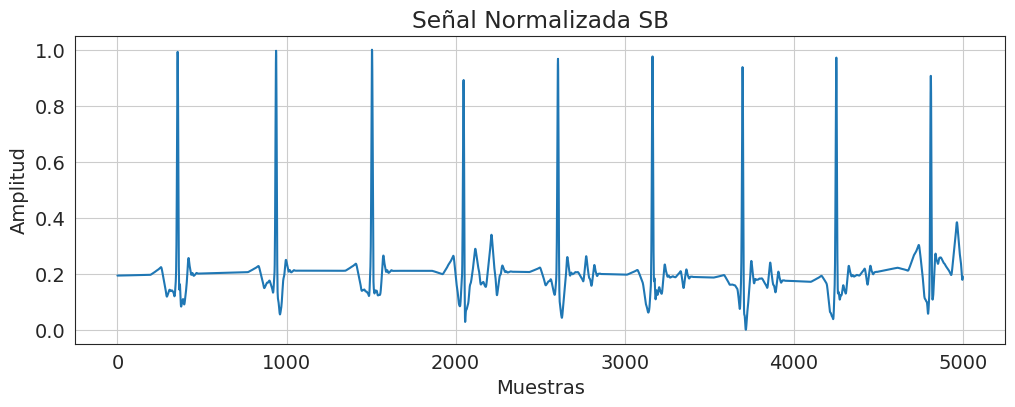

In [45]:
primer_archivo = list(datos_ecg_sbfil_normalizados.keys())[0]
primer_senal_normalizada = datos_ecg_sbfil_normalizados[primer_archivo]

plt.figure(figsize=(12, 4))
plt.plot(primer_senal_normalizada)
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title(f"Señal Normalizada SB")
plt.grid()
plt.show()

Como se evidencia el proceso de normalizacion, genero un pequeño offset, de manera similar al proyecto 2, se aplica de nuevo un detrend

In [46]:
# Diccionario para almacenar las señales detrended
datos_ecg_sbfil_detrended = {}

# Recorre cada señal en el diccionario
for archivo, senal in datos_ecg_sbfil_normalizados.items():
    senal_detrended = detrend(senal)
    datos_ecg_sbfil_detrended[archivo] = senal_detrended


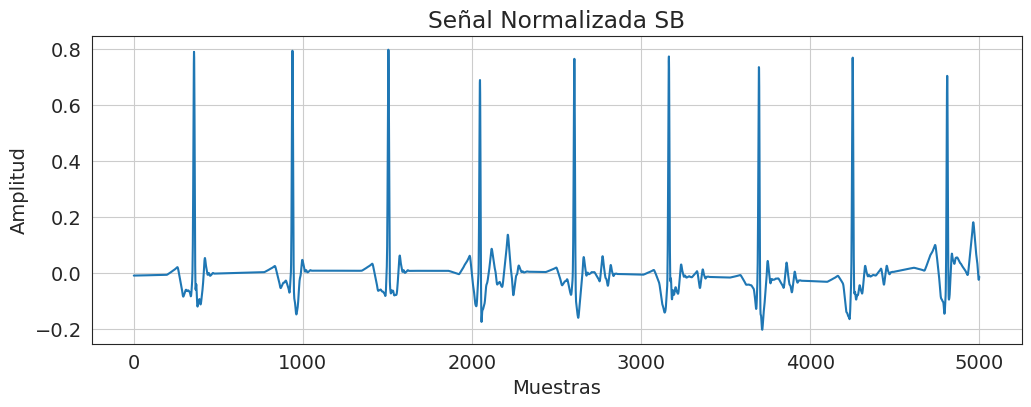

In [47]:
# Visualizacion de una señal detrended para verificar
primer_archivo = list(datos_ecg_sbfil_detrended.keys())[0]
primer_senal_detrended = datos_ecg_sbfil_detrended[primer_archivo]

plt.figure(figsize=(12, 4))
plt.plot(primer_senal_detrended)
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title(f"Señal Normalizada SB")
plt.grid()
plt.show()

### **5.** Para cada señal extraer la frecuencia que contiene la máxima potencia usando Welch (15%)

De igual manera, la obtencion de las frecuencias de contienen la maxima Potencia mediante el periodograma, se va a realizar unicamente a las senales SB, y posteriormente en la creacion de la rutina se realiza tambien para las senales AFIB.

Los parámetros seleccionados para el cálculo del periodograma de Welch aseguran una estimación precisa de las frecuencias en las señales ECG de 5000 muestras, como las que se encuentran en nuestros sets de datos. Usar un tamaño de ventana de 500 muestras, equivalente al 10% de la longitud total de la señal, proporciona un buen equilibrio entre la resolución en frecuencia y la suavidad de la estimación, mientras que el solapamiento del 50% (250 muestras) mejora la estabilidad del análisis al reducir la varianza. Además, la ventana de Hann minimiza las fugas espectrales, logrando un espectro más preciso y limpio, ideal para identificar las frecuencias de máxima potencia en un análisis fiable y eficiente [16].

In [48]:
# Parámetros de Welch
fs = 500  # Frecuencia de muestreo
window_size = 500  # Tamaño de la ventana
overlap = window_size // 2
window = hann(window_size)

# Diccionario para almacenar la frecuencia de máxima potencia de cada señal
frecuencias_sbmax_potencia = {}

for archivo, senal in datos_ecg_sbfil_detrended.items():
    frecuencias, potencia = welch(senal, fs=fs, window=window, nperseg=window_size, noverlap=overlap)
    indice_max_potencia = np.argmax(potencia)
    frecuencia_sbmax_potencia = frecuencias[indice_max_potencia]
    frecuencias_sbmax_potencia[archivo] = frecuencia_sbmax_potencia

print("Frecuencias de máxima potencia por señal para registros SB (primeras 5):")
for archivo, frecuencia in list(frecuencias_sbmax_potencia.items())[:5]:
    print(f"{archivo}: {frecuencia:.2f} Hz")

Frecuencias de máxima potencia por señal para registros SB (primeras 5):
MUSE_20180118_125036_12000.csv: 6.00 Hz
MUSE_20180115_134802_62000.csv: 8.00 Hz
MUSE_20180113_183540_30000.csv: 13.00 Hz
MUSE_20180114_071609_13000.csv: 1.00 Hz
MUSE_20180113_121504_38000.csv: 6.00 Hz


Ahora se crea una funcion que realiza este proceso, con la finalidad de implementarla posteriormente en la rutina.

In [49]:
def calcular_frecuencia_max_potencia(senal, fs, window_size=500, overlap_ratio=0.5):
    # Calcula la frecuencia de máxima potencia usando el método de Welch
    overlap = int(window_size * overlap_ratio)
    window = hann(window_size)
    frecuencias, potencia = welch(senal, fs=fs, window=window, nperseg=window_size, noverlap=overlap)
    indice_max_potencia = np.argmax(potencia)
    return frecuencias[indice_max_potencia]

###  6. Crear una rutina que aplique sobre todos los archivos de la base de datos las rutina 3 al 5 y almacene los resultados en un dataframe donde se pueda registro, tipo de patología y el frecuencia de máxima potencia (fMP):


Se realiza un funcion que permite realizar la rutina que perimite realizar puntos del 3 al 5 de manera adecuada para las señales de la derivacion II de cada registro de interes.

In [50]:
# Función principal para procesar todas las señales y almacenar los resultados
def procesar_senales(datos_ecg, patologia, fs=500):
    resultados = []

    for archivo, senal in datos_ecg.items():
        senal = senal[1:].astype(float)

        # flujo 2 completo (detrend, wavelet, y filtro pasabajas)
        senal_filtrada = flujo_2(senal, fs)

        # Aplicar detrend antes de la normalización
        senal_filtrada_detrended = detrend(senal_filtrada)

        # Normalizar la señal
        x_min, x_max = np.min(senal_filtrada_detrended), np.max(senal_filtrada_detrended)
        senal_normalizada = normalize_ecg(senal_filtrada_detrended, x_min, x_max)

        # Aplicar detrend nuevamente después de la normalización
        senal_normalizada_detrended = detrend(senal_normalizada)

        # frecuencia de máxima potencia
        frecuencia_max_potencia = calcular_frecuencia_max_potencia(senal_normalizada_detrended, fs)

        # Se almacenan los resultados en el formato de DataFrame
        resultados.append({
            "Registro": archivo,
            "Patologia": patologia,
            "fMP(Hz)": frecuencia_max_potencia
        })

    # Se crea un dataframe con los resultados
    df_resultados = pd.DataFrame(resultados)
    return df_resultados

In [51]:
# aplicación rutina para AFIB
df_afib = procesar_senales(datos_ecg_afib, "AFIB", fs=500)

# DataFrame resultante
df_afib

Registro Patologia  fMP(Hz)
0     MUSE_20180120_123458_66000.csv      AFIB     11.0
1     MUSE_20180118_133356_60000.csv      AFIB      1.0
2     MUSE_20180712_161418_70000.csv      AFIB     11.0
3     MUSE_20180118_120030_66000.csv      AFIB      8.0
4     MUSE_20180113_134303_70000.csv      AFIB      3.0
...                              ...       ...      ...
1775  MUSE_20180111_170102_10000.csv      AFIB      8.0
1776  MUSE_20180113_122043_40000.csv      AFIB      2.0
1777  MUSE_20180114_070350_28000.csv      AFIB     11.0
1778  MUSE_20180112_072524_02000.csv      AFIB     10.0
1779  MUSE_20180112_123242_45000.csv      AFIB     15.0

[1780 rows x 3 columns]

In [52]:
#Aplicacion rutina para registros SB
df_sb = procesar_senales(datos_ecg_sb_dict, "SB", fs=500)

# DataFrame resultante
df_sb

/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Registro Patologia  fMP(Hz)
0     MUSE_20180118_125036_12000.csv        SB      6.0
1     MUSE_20180115_134802_62000.csv        SB      8.0
2     MUSE_20180113_183540_30000.csv        SB     13.0
3     MUSE_20180114_071609_13000.csv        SB      1.0
4     MUSE_20180113_121504_38000.csv        SB      6.0
...                              ...       ...      ...
3884  MUSE_20180118_180837_78000.csv        SB      1.0
3885  MUSE_20180120_122653_59000.csv        SB      8.0
3886  MUSE_20180118_131742_83000.csv        SB      9.0
3887  MUSE_20180118_123746_35000.csv        SB     13.0
3888  MUSE_20180113_120827_43000.csv        SB     10.0

[3889 rows x 3 columns]

Ahora se juntan ambos dataframes

In [53]:
df_combined = pd.concat([df_afib, df_sb], ignore_index=True)

# Se guarda el dataframe combinado en un archivo CSV
df_combined.to_csv('resultados_ecg.csv', index=False)

df_combined

Registro Patologia  fMP(Hz)
0     MUSE_20180120_123458_66000.csv      AFIB     11.0
1     MUSE_20180118_133356_60000.csv      AFIB      1.0
2     MUSE_20180712_161418_70000.csv      AFIB     11.0
3     MUSE_20180118_120030_66000.csv      AFIB      8.0
4     MUSE_20180113_134303_70000.csv      AFIB      3.0
...                              ...       ...      ...
5664  MUSE_20180118_180837_78000.csv        SB      1.0
5665  MUSE_20180120_122653_59000.csv        SB      8.0
5666  MUSE_20180118_131742_83000.csv        SB      9.0
5667  MUSE_20180118_123746_35000.csv        SB     13.0
5668  MUSE_20180113_120827_43000.csv        SB     10.0

[5669 rows x 3 columns]

## **Analisis con estadistica descriptiva**


En primer lugar, se carga el dataframe donde se almacenaron los resultados obtenidos en el Proyecto 2

In [55]:
# Carga del dataframe obtenido en en anterior proyecto
data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/DataFrame.csv')

data

Registro Estado  fMP(Hz)  sFSB
0     MUSE_20180116_132337_80000.csv   AFIB      2.5     1
1     MUSE_20180712_160542_23000.csv   AFIB      6.3    76
2     MUSE_20180113_132107_62000.csv   AFIB      4.0    51
3     MUSE_20180116_170744_66000.csv   AFIB      1.6    76
4     MUSE_20180116_122717_82000.csv   AFIB      4.1    68
...                              ...    ...      ...   ...
5664  MUSE_20180113_183540_30000.csv     SB      2.9    17
5665  MUSE_20180112_133103_33000.csv     SB      2.9    55
5666  MUSE_20180115_115626_42000.csv     SB      3.4   109
5667  MUSE_20180113_182022_25000.csv     SB      1.8    30
5668  MUSE_20180113_185246_68000.csv     SB      0.9   106

[5669 rows x 4 columns]

En esta siguiente etapa del proyecto, se llevará a cabo un análisis de estadística descriptiva para comparar los resultados obtenidos en este nuevo Proyecto 3 con los del Proyecto 2. En el Proyecto 2, se partía de señales ECG ya filtradas, mientras que en el Proyecto 3 se ha trabajado desde señales originales (sin filtrar) aplicando un nuevo flujo de procesamiento. El objetivo de este análisis es evaluar cómo difieren las frecuencias de máxima potencia (fMP) para cada condición (AFIB y SB) entre ambos proyectos. Para ello, se utilizarán los DataFrames correspondientes, lo que permitirá comparar la efectividad de los procesos de filtrado en la identificación precisa de las frecuencias clave en ambas condiciones.

Para este análisis, se utilizarán boxplots para comparar las frecuencias que contienen la máxima potencia (fMP) entre ambos proyectos para cada condición (AFIB y SB). El uso de boxplots es una excelente decisión ya que permite visualizar de manera clara la distribución de los datos, incluyendo la mediana, los cuartiles, y posibles valores atípicos en cada grupo [17]. Esto resulta útil en este caso, ya que queremos comparar cómo los diferentes procesos de filtrado (señales prefiltradas en el Proyecto 2 versus el filtrado aplicado en Proyecto 3) afectan las frecuencias de máxima potencia. Los boxplots nos ayudarán a identificar no solo las diferencias en las medianas entre los dos proyectos, sino también a evaluar la variabilidad y la presencia de posibles outliers que podrían indicar señales con comportamientos anómalos [17].

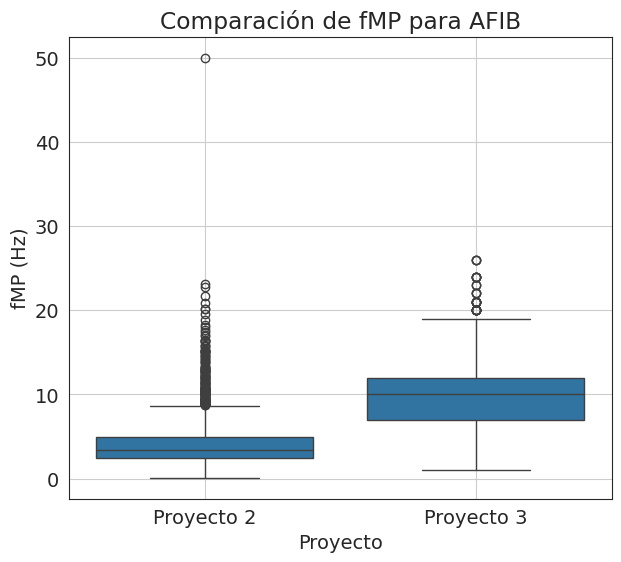

In [56]:
import seaborn as sns

# Datos de fMP del Proyecto 2
fmp_data_afib = data[data['Estado'] == 'AFIB']['fMP(Hz)']

# datos de fMP del Proyecto 3
fmp_combined_afib = df_combined[df_combined['Patologia'] == 'AFIB']['fMP(Hz)']

# DataFrame para facilitar la graficación con seaborn
df_plot = pd.DataFrame({
    'Proyecto': ['Proyecto 2'] * len(fmp_data_afib) + ['Proyecto 3'] * len(fmp_combined_afib),
    'fMP(Hz)': pd.concat([fmp_data_afib, fmp_combined_afib])
})

plt.figure(figsize=(7, 6))
sns.boxplot(x='Proyecto', y='fMP(Hz)', data=df_plot)
plt.title('Comparación de fMP para AFIB')
plt.ylabel('fMP (Hz)')
plt.grid(True)
plt.show()

Al comparar la frecuencia de máxima potencia (fMP) entre los dos proyectos para la condición AFIB, se observa que el Proyecto 3 arroja frecuencias significativamente más altas, con una mediana cercana a los 10 Hz, mientras que en el Proyecto 2 la mediana está alrededor de 5 Hz. El uso del Periodograma de Welch en el Proyecto 3, junto con un flujo de filtrado menos restrictivo, permitió captar un mayor rango de frecuencias. Sin embargo, esto no necesariamente indica que los resultados sean "mejores", sino que reflejan una mayor sensibilidad a componentes de alta frecuencia que podrían incluir tanto información relevante como ruido.

El Proyecto 2, con un prefiltrado probablemente mas restrictivo o de mayor complejidad, y el uso de la Transformada de Fourier, se centró en frecuencias más bajas, alineándose más con las características fisiológicas típicas de las señales cardíacas. Esta simplificación puede ser ventajosa para reducir la interferencia en señales complejas como las de AFIB [18], donde un exceso de detalles puede dificultar el análisis clínico.

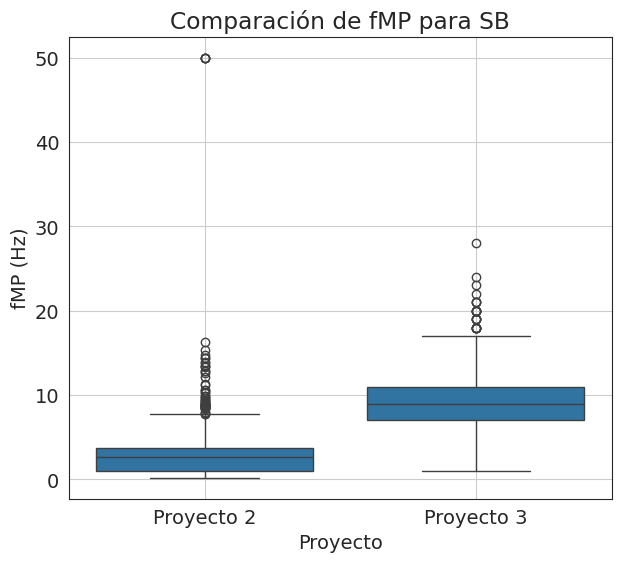

In [57]:
# Datos de fMP del Proyecto 2 para SB
fmp_data_sb = data[data['Estado'] == 'SB']['fMP(Hz)']

# datos de fMP del Proyecto 3 para SB
fmp_combined_sb = df_combined[df_combined['Patologia'] == 'SB']['fMP(Hz)']

# DataFrame para facilitar la graficación con seaborn
df_plot_sb = pd.DataFrame({
    'Proyecto': ['Proyecto 2'] * len(fmp_data_sb) + ['Proyecto 3'] * len(fmp_combined_sb),
    'fMP(Hz)': pd.concat([fmp_data_sb, fmp_combined_sb])
})

plt.figure(figsize=(7, 6))
sns.boxplot(x='Proyecto', y='fMP(Hz)', data=df_plot_sb)
plt.title('Comparación de fMP para SB')
plt.ylabel('fMP (Hz)')
plt.grid(True)
plt.show()

Al comparar la frecuencia de máxima potencia (fMP) entre los dos proyectos para la condición SB, se observa un patrón similar al análisis realizado para AFIB, pero con algunas diferencias clave. En el Proyecto 3, la mediana de las fMP es más alta, alrededor de 10 Hz, mientras que en el Proyecto 2 se encuentra más cercana a los 5 Hz. Sin embargo, las señales de SB presentan una menor dispersión en comparación con AFIB, reflejando la naturaleza más controlada y estable de esta condición cardíaca [19].

El uso del Periodograma de Welch en el Proyecto 3 permitió capturar un rango más amplio de frecuencias, lo que resultó en un aumento en las fMP detectadas. Esto puede ser beneficioso para análisis que requieran identificar detalles más finos en la señal, pero también puede implicar una mayor susceptibilidad al capturar ruido, especialmente en señales menos complejas como SB.

En contraste, el Proyecto 2 mostró una distribución más concentrada en frecuencias bajas, lo que puede reflejar un prefiltrado más restrictivo que prioriza la eliminación de ruido a expensas de componentes de alta frecuencia. Esto puede ser ventajoso para señales como SB, donde la simplicidad de la señal puede hacer que las frecuencias altas captadas en el Proyecto 3 no sean tan relevantes desde el punto de vista clínico.

## **Analisis de diferencias estadisticas**

### Planteamiento de hipotesis nula (H0) y alternativa (H1)

Para determinar si existen diferencias estadísticas entre las poblaciones de estudio (Proyecto 1 y Proyecto 2) en la variable fMP para las dos patologias (AFIB y SB), se realizarán pruebas para evualuar los supuestos de normalidad, homocedasticidad e independencia. A continuacion se especifican las hipotesis nulas (H0) y las hipotesis alternativas (H1) para cada supuesto.

**Para Normalidad:**

H0: Los datos provienen de una distribucion normal.

H1: Los datos no provienen de una distribucion normal.

**Para Homocedasticidad:**

H0: La varianza entre los grupos es constante (hay homocedasticidad).

H1: La varianza entre los grupos no es constante (hay heterocedasticidad).

**Supuesto de independencia:** Se da por aceptado en este contexto, ya que los registros del estudio provienen de diferentes poblaciones, es decir, individuos con diferentes enfermedades cardiacas y que ademas los las senales en con las cuales se ha trabajado, han tenido un diferente flujo de procesamiento. Esto implica que no hay influencia entre los grupos, lo que asegura que los datos sean independientes entre sí.

### **Seleccion del tipo de prueba**

Para comprobar el supuesto de normalidad, se utilizará la prueba de **Kolmogorov-Smirnov**. Esta prueba es adecuada dado el tamaño de los grupos poblacionales: **1780** registros para AFIB y **3889** para SB tanto para el Proyecto 2 como en Proyecto 3. La prueba de Kolmogorov-Smirnov es preferida en este caso porque, al tener muestras grandes, ofrece una evaluación robusta de si los datos siguen una distribución normal.

Por otro lado, para verificar el supuesto de homocedasticidad, se empleará la prueba de **Levene**. Esta prueba es especialmente versátil porque no asume normalidad en los datos y es efectiva en la evaluación de la igualdad de varianzas entre los grupos, independientemente de la forma de sus distribuciones.

NORMALIDAD DE AFIB ENTRE EL P2 Y P3

In [58]:
from scipy.stats import kstest

alpha = 0.05  # Nivel de significancia

# Prueba de Kolmogorov-Smirnov para fMP de AFIB
ks_stat_afib, p_value_afib = kstest(fmp_data_afib, 'norm', args=(fmp_data_afib.mean(), fmp_data_afib.std()))
ks_stat_combined_afib, p_value_combined_afib = kstest(fmp_combined_afib, 'norm', args=(fmp_combined_afib.mean(), fmp_combined_afib.std()))

# Resultados para AFIB
print(f"Estadístico KS para AFIB (Proyecto 2): {ks_stat_afib}")
print(f"Valor p para AFIB (Proyecto 2): {p_value_afib}")

print(f"Estadístico KS para AFIB (Proyecto 3): {ks_stat_combined_afib}")
print(f"Valor p para AFIB (Proyecto 3): {p_value_combined_afib}\n")

# Se verifica si se rechaza la hipótesis nula para AFIB (Proyecto 2)
if p_value_afib < alpha:
    print("Se rechaza la hipótesis nula para AFIB (Proyecto 2): Los datos no siguen una distribución normal.")
else:
    print("No se rechaza la hipótesis nula para AFIB (Proyecto 2): Los datos siguen una distribución normal.")

# Se verifica si se rechaza la hipótesis nula para AFIB (Proyecto 3)
if p_value_combined_afib < alpha:
    print("Se rechaza la hipótesis nula para AFIB (Proyecto 3): Los datos no siguen una distribución normal.")
else:
    print("No se rechaza la hipótesis nula para AFIB (Proyecto 3): Los datos siguen una distribución normal.")

Estadístico KS para AFIB (Proyecto 2): 0.184700545770782
Valor p para AFIB (Proyecto 2): 1.2667389525931834e-53
Estadístico KS para AFIB (Proyecto 3): 0.15191972737553872
Valor p para AFIB (Proyecto 3): 2.4707746561725736e-36

Se rechaza la hipótesis nula para AFIB (Proyecto 2): Los datos no siguen una distribución normal.
Se rechaza la hipótesis nula para AFIB (Proyecto 3): Los datos no siguen una distribución normal.


Los resultados de la prueba de Kolmogorov-Smirnov para ambas series de datos (Proyecto 2 y Proyecto 3) de la condición AFIB muestran valores p extremadamente bajos (prácticamente cero), lo que lleva a rechazar la hipótesis nula de que los datos siguen una distribución normal en ambos casos. Esto implica que las fMP para las señales de AFIB no se distribuyen normalmente en ninguno de los dos proyectos, por lo que será necesario utilizar pruebas estadísticas no paramétricas para realizar comparaciones entre los grupos con patologia AFIB.

NORMALIDAD SB ENTRE P2 Y P3

In [59]:
# Prueba de Kolmogorov-Smirnov para fMP de SB
ks_stat_sb, p_value_sb = kstest(fmp_data_sb, 'norm', args=(fmp_data_sb.mean(), fmp_data_sb.std()))
ks_stat_combined_sb, p_value_combined_sb = kstest(fmp_combined_sb, 'norm', args=(fmp_combined_sb.mean(), fmp_combined_sb.std()))

# Resultados para SB
print(f"Estadístico KS para SB (Proyecto 2): {ks_stat_sb}")
print(f"Valor p para SB (Proyecto 2): {p_value_sb}")

print(f"Estadístico KS para SB (Proyecto 3): {ks_stat_combined_sb}")
print(f"Valor p para SB (Proyecto 3): {p_value_combined_sb}\n")

# Se verifica si se rechaza la hipótesis nula para SB (Proyecto 2)
if p_value_sb < alpha:
    print("Se rechaza la hipótesis nula para SB (Proyecto 2): Los datos no siguen una distribución normal.")
else:
    print("No se rechaza la hipótesis nula para SB (Proyecto 2): Los datos siguen una distribución normal.")

# Se verifica si se rechaza la hipótesis nula para SB (Proyecto 3)
if p_value_combined_sb < alpha:
    print("Se rechaza la hipótesis nula para SB (Proyecto 3): Los datos no siguen una distribución normal.")
else:
    print("No se rechaza la hipótesis nula para SB (Proyecto 3): Los datos siguen una distribución normal.")

Estadístico KS para SB (Proyecto 2): 0.20380633479154178
Valor p para SB (Proyecto 2): 4.1220764249130304e-142
Estadístico KS para SB (Proyecto 3): 0.10762126713073722
Valor p para SB (Proyecto 3): 1.112271116522688e-39

Se rechaza la hipótesis nula para SB (Proyecto 2): Los datos no siguen una distribución normal.
Se rechaza la hipótesis nula para SB (Proyecto 3): Los datos no siguen una distribución normal.


Los resultados de la prueba de Kolmogorov-Smirnov para las señales de SB en ambos proyectos también muestran valores p extremadamente bajos, lo que indica que se rechaza la hipótesis nula de normalidad tanto para el Proyecto 2 como para el Proyecto 3. Esto confirma que los datos de fMP para SB no se distribuyen normalmente en ninguno de los dos conjuntos. Dado este resultado, al igual que en el análisis de AFIB, será necesario utilizar pruebas no paramétricas para comparar las distribuciones de fMP entre los dos proyectos.

HOMOCEDASTICIDAD DE AFIB ENTRE EL P2 Y P3

In [60]:
from scipy.stats import levene

# Prueba de Levene para homocedasticidad entre los datos de AFIB del Proyecto 2 y Proyecto 3
stat_levene_afib, p_value_levene_afib = levene(fmp_data_afib, fmp_combined_afib)

# Resultados de la prueba de Levene
print(f"Estadístico de Levene para AFIB: {stat_levene_afib}")
print(f"Valor p de Levene para AFIB: {p_value_levene_afib}")

# Verificación de la hipótesis nula
if p_value_levene_afib < alpha:
    print("Se rechaza la hipótesis nula: Las varianzas no son iguales (Hay heterocedasticidad).")
else:
    print("No se rechaza la hipótesis nula: Las varianzas son iguales (Hay homocedasticidad).")

Estadístico de Levene para AFIB: 232.73376649169782
Valor p de Levene para AFIB: 5.984737695628576e-51
Se rechaza la hipótesis nula: Las varianzas no son iguales (Hay heterocedasticidad).


El resultado de la prueba de Levene para las señales de AFIB muestra un valor p extremadamente bajo, lo que lleva a rechazar la hipótesis nula de homocedasticidad. Esto indica que no hay igualdad de varianzas entre los grupos (Proyecto 2 y Proyecto 3), es decir, las varianzas difieren significativamente. Por lo tanto, cualquier comparación entre los proyectos deberá hacerse utilizando pruebas que no asuman homogeneidad de varianzas, como la prueba U de Mann-Whitney en lugar de la prueba t estándar.

HOMOCEDASTICIDAD DE SB ENTRE EL P2 Y P3

In [61]:
# Prueba de Levene para homocedasticidad entre los datos de SB del Proyecto 2 y Proyecto 3
stat_levene_sb, p_value_levene_sb = levene(fmp_data_sb, fmp_combined_sb)

# Resultados de la prueba de Levene
print(f"Estadístico de Levene para SB: {stat_levene_sb}")
print(f"Valor p de Levene para SB: {p_value_levene_sb}")

# Verificación de la hipótesis nula
if p_value_levene_sb < alpha:
    print("Se rechaza la hipótesis nula: Las varianzas no son iguales (Hay heterocedasticidad).")
else:
    print("No se rechaza la hipótesis nula: Las varianzas son iguales (Hay homocedasticidad).")

Estadístico de Levene para SB: 687.1160690807437
Valor p de Levene para SB: 3.339493955261905e-145
Se rechaza la hipótesis nula: Las varianzas no son iguales (Hay heterocedasticidad).


El resultado de la prueba de Levene para las señales de SB también muestra un valor p extremadamente bajo, lo que nuevamente nos lleva a rechazar la hipótesis nula de homocedasticidad. Esto significa que las varianzas entre los grupos (Proyecto 2 y Proyecto 3) no son iguales, indicando heterocedasticidad. Al igual que en el análisis para AFIB, esto implica que para comparar las fMP entre los dos proyectos será necesario utilizar pruebas no paramétricas que no asuman igualdad de varianzas, como la prueba U de Mann-Whitney, en lugar de pruebas que asuman homogeneidad.

### **Seleccion de prueba Parametrica o No Parametrica**

Dado que los resultados de las pruebas de normalidad y homocedasticidad indicaron que los datos no siguen una distribución normal y presentan varianzas desiguales entre los grupos, se decide utilizar una **prueba no paramétrica** para comparar las poblaciones del Proyecto 2 y el Proyecto 3. La prueba **U de Mann-Whitney** es la más adecuada en este caso, ya que no requiere que los datos cumplan con los supuestos de normalidad o homogeneidad de varianzas [20]. Esta prueba permite evaluar si existen diferencias estadísticamente significativas entre los resultados en los Proyectos para la variable fMP, comparando las distribuciones de ambos grupos sin asumir una forma específica de las mismas.

**Se plantean las hipotesis para la prueba U de Mann-Whitney:**

H0: No hay diferencias estadisticas significativas en las distribuciones de las dos poblaciones (Medianas iguales)

H1: Existen diferencias estadisticas significativas en las distribuciones de las dos poblaciones (Medianas diferentes)

SE REALIZA LA PRUEBA U PARA LA PATOLOGIA AFIB

In [62]:
from scipy.stats import mannwhitneyu

# Prueba U de Mann-Whitney para comparar fMP de AFIB entre Proyecto 2 y Proyecto 3
u_stat_afib, p_value_u_afib = mannwhitneyu(fmp_data_afib, fmp_combined_afib, alternative='two-sided')

# Resultados de la prueba U de Mann-Whitney
print(f"Estadístico U para AFIB: {u_stat_afib}")
print(f"Valor p para AFIB: {p_value_u_afib}")

# Verificación de la hipótesis nula
if p_value_u_afib < alpha:
    print("Se rechaza la hipótesis nula: Existen diferencias estadísticas significativas en las distribuciones de fMP para AFIB entre los proyectos.")
else:
    print("No se rechaza la hipótesis nula: No existen diferencias estadísticas significativas en las distribuciones de fMP para AFIB entre los proyectos.")

Estadístico U para AFIB: 654489.0
Valor p para AFIB: 3.4303181790202854e-202
Se rechaza la hipótesis nula: Existen diferencias estadísticas significativas en las distribuciones de fMP para AFIB entre los proyectos.


Los resultados de la prueba U de Mann-Whitney para la condición AFIB muestran un valor p extremadamente bajo, lo que nos lleva a rechazar la hipótesis nula. Esto indica que existen diferencias estadísticas significativas en las distribuciones de la frecuencia de máxima potencia (fMP) entre el Proyecto 2 y el Proyecto 3 para las señales de AFIB.

De esta manera, los métodos de procesamiento y análisis empleados en el Proyecto 3 generan resultados que son estadísticamente diferentes en comparación con los obtenidos en el Proyecto 2, lo que refuerza la idea de que el flujo de filtrado y el uso del Periodograma de Welch han impactado significativamente en los resultados. Esta diferencia sugiere que el enfoque implementado en el Proyecto 3 logra capturar características de frecuencia que el método anterior pudo haber pasado por alto o filtrado en exceso.

SE REALIZA LA PRUEBA U PARA LA PATOLOGIA SB

In [63]:
# Prueba U de Mann-Whitney para comparar fMP de SB entre Proyecto 2 y Proyecto 3
u_stat_sb, p_value_u_sb = mannwhitneyu(fmp_data_sb, fmp_combined_sb, alternative='two-sided')

# Resultados de la prueba U de Mann-Whitney
print(f"Estadístico U para SB: {u_stat_sb}")
print(f"Valor p para SB: {p_value_u_sb}")

# Verificación de la hipótesis nula
if p_value_u_sb < alpha:
    print("Se rechaza la hipótesis nula: Existen diferencias estadísticas significativas en las distribuciones de fMP para SB entre los proyectos.")
else:
    print("No se rechaza la hipótesis nula: No existen diferencias estadísticas significativas en las distribuciones de fMP para SB entre los proyectos.")

Estadístico U para SB: 1171893.0
Valor p para SB: 0.0
Se rechaza la hipótesis nula: Existen diferencias estadísticas significativas en las distribuciones de fMP para SB entre los proyectos.


El resultado de la prueba U de Mann-Whitney para la condición SB también muestra un valor p de prácticamente cero, lo que lleva a rechazar la hipótesis nula. Esto indica que existen diferencias estadísticas significativas en las distribuciones de frecuencia de máxima potencia (fMP) entre el Proyecto 2 y el Proyecto 3 para las señales de SB.

Este hallazgo refuerza la conclusión de que los métodos de filtrado y análisis utilizados en el Proyecto 3, específicamente el uso del Periodograma de Welch, han producido resultados significativamente distintos en comparación con el prefiltrado y análisis espectral tradicional del Proyecto 2. Incluso en una condición más estable como la bradicardia sinusal, el flujo de procesamiento del Proyecto 3 ha capturado información de frecuencia que el enfoque anterior no logró preservar.

## **Conclusiones**

Los análisis realizados en este proyecto, que incluyeron tanto técnicas de estadística descriptiva como inferencial, han mostrado diferencias significativas entre los resultados obtenidos en el Proyecto 2 y el Proyecto 3 al analizar las señales ECG para las patologías de fibrilación auricular (AFIB) y bradicardia sinusal (SB). A través del uso del Periodograma de Welch en el Proyecto 3, se observó que este enfoque fue capaz de detectar frecuencias de máxima potencia (fMP) más elevadas en comparación con las estimaciones obtenidas mediante la Transformada de Fourier utilizada en el Proyecto 2.

El flujo de filtrado implementado en el Proyecto 3, que incluyó un proceso controlado de limpieza antes de aplicar el análisis espectral, parece ser más eficaz en la preservación de las componentes de frecuencia más altas, especialmente en señales con mayor irregularidad como las de AFIB. Esto se refleja en las diferencias estadísticas significativas encontradas en las pruebas U de Mann-Whitney, que indican que los resultados de ambos proyectos no son equivalentes, sugiriendo que el enfoque del Proyecto 3 capturó información que el Proyecto 2 podría haber pasado por alto debido a un filtrado más restrictivo.

Sin embargo, el hecho de que el Proyecto 3 muestre frecuencias más altas no implica necesariamente que sus resultados sean intrínsecamente "mejores" que los del Proyecto 2. La mayor sensibilidad del flujo de filtrado y del Periodograma de Welch para capturar frecuencias más elevadas podría reflejar una mayor capacidad para identificar detalles en las señales, pero también introduce la posibilidad de que se estén capturando componentes de ruido que no necesariamente contribuyen a un diagnóstico más preciso.

## **Bibliografía**

* [1] Jenkal, S. E. A. D. (s/f). Empirical Wavelet Transform Based ECG Signal Filtering Method. Wiley.com. Recuperado el 2 de noviembre de 2024, de https://onlinelibrary.wiley.com/doi/10.1155/2024/9050909


* [2] Sarla, & Singh, D. (2022). Performance analysis of wavelet filters for heart rate variability analysis. En Lecture Notes in Mechanical Engineering (pp. 107–116). Springer Singapore.

* [3] A novel wavelet-based filtering strategy to remove powerline interference from electrocardiograms with atrial fibrillation. (s/f). En arXiv. Recuperado el 2 de noviembre de 2024, de https://arxiv.org/html/2401.13067v1

* [4] Rodríguez, O. J. O. (s/f). Determinación de los parámetros asociados al filtro wavelet por umbralización aplicado a filtrado de interferencias electrocardiográficas. Unirioja.es. Recuperado el 2 de noviembre de 2024, de https://dialnet.unirioja.es/servlet/articulo?codigo=6299722

* [5] Chen, C.-C., & Tsui, F. R. (2020). Comparing different wavelet transforms on removing electrocardiogram baseline wanders and special trends. BMC Medical Informatics and Decision Making, 20(S11). https://doi.org/10.1186/s12911-020-01349-x

* [6] Sarla, & Singh, D. (2022). Performance analysis of wavelet filters for heart rate variability analysis. En Lecture Notes in Mechanical Engineering (pp. 107–116). Springer Singapore.


* [7] Sevi̇ndi̇r, H. K., Çetu̇nkaya, S., & Şayli̇, Ö. (2015). Wavelet transform based noise removal from ECG signal for accurate heart rate detection using ECG. 2015 Medical Technologies National Conference (TIPTEKNO), 1–4.

* [8] Cornelia, G., & Romulus, R. (s/f). Ecg signals processing using wavelets. Org.tr. Recuperado el 2 de noviembre de 2024, de https://www.emo.org.tr/ekler/c1cd7b4cdd34596_ek.pdf

* [9] S. Saxena, R. Jais and M. K. Hota, "Removal of Powerline Interference from ECG Signal using FIR, IIR, DWT and NLMS Adaptive Filter," 2019 International Conference on Communication and Signal Processing (ICCSP), Chennai, India, 2019, pp. 0012-0016, doi: 10.1109/ICCSP.2019.8698112.

* [10] Soni, S. S. B. M. (s/f). Design of Simulink Model to denoise ECG signal using various IIR & FIR filters. Researchgate.net. Recuperado el 3 de noviembre de 2024, de https://www.researchgate.net/publication/271462420_Design_of_Simulink_Model_to_denoise_ECG_signal_using_various_IIR_FIR_filters

* [11] T. M. Chieng, Y. W. Hau and Z. Omar, "The Study and Comparison between Various Digital Filters for ECG De-noising," 2018 IEEE-EMBS Conference on Biomedical Engineering and Sciences (IECBES), Sarawak, Malaysia, 2018, pp. 226-232, doi: 10.1109/IECBES.2018.8626661.

* [12] N. Das and M. Chakraborty, "Performance analysis of FIR and IIR filters for ECG signal denoising based on SNR," 2017 Third International Conference on Research in Computational Intelligence and Communication Networks (ICRCICN), Kolkata, India, 2017, pp. 90-97, doi: 10.1109/ICRCICN.2017.8234487.

* [13] Badr, A. (1995). A computer environment for ECG waveforms morphological classification.

* [14] Thakor, N. V., & Zhu, Y. S. (1991). Applications of adaptive filtering to ECG analysis: noise cancellation and arrhythmia detection. IEEE transactions on biomedical engineering, 38(8), 785-794.

* [15] Shin, S. W., Kim, K. S., Song, C. G., Lee, J. W., Kim, J. H., & Jeung, G. W. (2015). Removal of baseline wandering in ECG signal by improved detrending method. Bio-medical materials and engineering, 26(s1), S1087-S1093.

* [16] Goel, S., Kaur, G., & Tomar, P. (2015, September). Performance analysis of Welch and Blackman Nuttall window for noise reduction of ECG. In 2015 International Conference on Signal Processing, Computing and Control (ISPCC) (pp. 87-91). IEEE.

* [17] Frigge, M., Hoaglin, D. C., & Iglewicz, B. (1989). Some implementations of the boxplot. The American Statistician, 43(1), 50-54.

* [18] Sai, Y. P. (2020, February). A review on arrhythmia classification using ECG signals. In 2020 IEEE International Students' Conference on Electrical, Electronics and Computer Science (SCEECS) (pp. 1-6). IEEE.

* [19] Eraut, D., & Shaw, D. B. (1971). Sinus bradycardia. British Heart Journa

* [20] IBM. "Tests Mann-Whitney U Test." IBM SPSS Statistics Documentation, IBM, 20 Oct. 2024, https://www.ibm.com/docs/es/spss-statistics/beta?topic=tests-mann-whitney-u-test.



